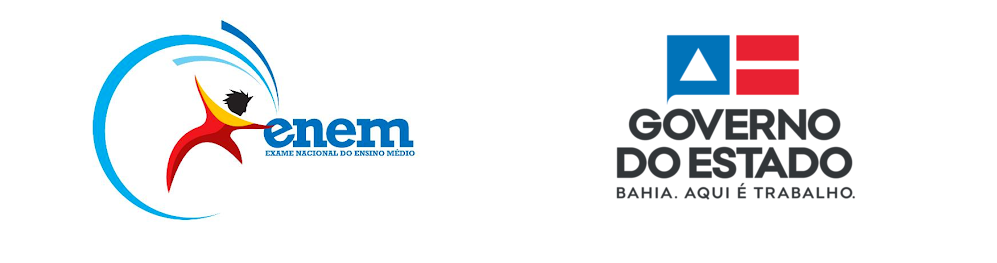

# <b><center>ANÁLISE ACERCA DO ENEM NO ESTADO DA BAHIA NOS ANOS DE 2017, 2018 E 2019</center><b>


# 1. Baixando, extraindo, lendo e filtrando os dados

<b> Obs:</b>Execute as células desse tópico apenas se for precisar utilizar os dados para execução do restante do projeto, se for apenas observar a análise não execute. São mais de 10 GB em dados após a extração.

## 1.1 Montando drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Instalando bibliotecas para importação dos dados

In [ ]:
!pip install wget

In [ ]:
!pip install geopandas

In [ ]:
!python -m pip install "dask[complete]"

## 1.3 Importando bibliotecas

In [5]:
import wget
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import numpy as np
import json
import sys
np.random.seed(0)
import geopandas as gpd
import random
from shapely.geometry import Point, Polygon
sns.set_palette('vlag', color_codes=True)

## 1.4 Baixando microdados do ENEM

In [ ]:
os.mkdir('/content/drive/My Drive/DADOS_ENEM')

url = "http://download.inep.gov.br/microdados/microdados_enem2017.zip"
wget.download(url, '/content/drive/My Drive/DADOS_ENEM/enem_2017.zip')

url = "http://download.inep.gov.br/microdados/microdados_enem2018.zip"
wget.download(url, '/content/drive/My Drive/DADOS_ENEM/enem_2018.zip')

url = "http://download.inep.gov.br/microdados/microdados_enem_2019.zip"
wget.download(url, '/content/drive/My Drive/DADOS_ENEM/enem_2019.zip')

## 1.5 Extraindo dados dos arquivoz Zip

In [ ]:
# Para extrair
with ZipFile('/content/drive/My Drive/DADOS_ENEM/enem_2017.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/DADOS_ENEM/enem_2017')

with ZipFile('/content/drive/My Drive/DADOS_ENEM/enem_2018.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/DADOS_ENEM/enem_2018')

with ZipFile('/content/drive/My Drive/DADOS_ENEM/enem_2019.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/DADOS_ENEM/enem_2019')

## 1.6 Lendo os dados com dask.dataframe

In [163]:
enem_2017 = dd.read_csv('drive/My Drive/DADOS_ENEM/enem_2017/Microdados Enem 2017/DADOS/MICRODADOS_ENEM_2017.csv', sep=';', encoding='latin1', assume_missing=True)
enem_2018 = dd.read_csv('drive/My Drive/DADOS_ENEM/enem_2018/DADOS/MICRODADOS_ENEM_2018.csv', sep=';', encoding='latin1', assume_missing=True)
enem_2019 = dd.read_csv('drive/My Drive/DADOS_ENEM/enem_2019/DADOS/MICRODADOS_ENEM_2019.csv', sep=';', encoding='latin1')

## 1.7 Filtrando apenas os registros da Bahia

In [164]:
enem_ba_2017 = pd.DataFrame(enem_2017[enem_2017['SG_UF_RESIDENCIA'] == 'BA'].compute()).reset_index(drop=True)
enem_ba_2018 = pd.DataFrame(enem_2018[enem_2018['SG_UF_RESIDENCIA'] == 'BA'].compute()).reset_index(drop=True)
enem_ba_2019 = pd.DataFrame(enem_2019[enem_2019['SG_UF_RESIDENCIA'] == 'BA'].compute()).reset_index(drop=True)

# 2. Tratamento dos dados prévio
### O principal objetivo é a melhoria do desempenho

In [165]:
# Excluíndo as colunas que são diferentes entre os dataframes

diff_17_19 = [element for element in enem_ba_2017.columns if element not in enem_ba_2019.columns]
diff_18_19 = [element for element in enem_ba_2018.columns if element not in enem_ba_2019.columns]
diff_17_18 = [element for element in enem_ba_2017.columns if element not in enem_ba_2018.columns]
diff_18_17 = [element for element in enem_ba_2018.columns if element not in enem_ba_2017.columns]
diff_19_17 = [element for element in enem_ba_2019.columns if element not in enem_ba_2017.columns]
diff_19_18 = [element for element in enem_ba_2019.columns if element not in enem_ba_2018.columns]
print('17-19:',diff_17_19,'\n18-19:',diff_18_19,'\n19-18:',diff_19_18,'\n17-18:',diff_17_18,'\n19-17:',diff_19_17,'\n18-17:',diff_18_17)

17-19: ['Q026', 'Q027'] 
18-19: ['Q026', 'Q027'] 
19-18: ['IN_TEMPO_ADICIONAL'] 
17-18: [] 
19-17: ['IN_TEMPO_ADICIONAL'] 
18-17: []


In [166]:
enem_ba_2017.drop(diff_17_19, axis=1, inplace=True)
enem_ba_2018.drop(diff_18_19, axis=1, inplace=True)
enem_ba_2019.drop(diff_19_17, axis=1, inplace=True)

## 2.1 Reduzindo todos os dados relacionados a atendimento especializado em 1 única coluna

Para melhoria de desempenho iremos agora reduzir a dimensão dos meus dados, há muitas colunas que não necessitaremos daqui pra frente (códigos,  gabirito, etc), há também conjuntos de colunas que podemos reduzir a apenas uma coluna, no caso reduziremos todos os dados do tópico de atendimento especializado (melhor observável dentro do dicionário de dados) e atendimento específico, por apenas uma coluna para cada, essa coluna representará o tópico ao todo.

Excluiremos quase todas as colunas do tópico de dados dos pedidos de recursos especializados e específicos para a realização das provas, deixando apenas a coluna IN_SEM_RECURSO, a qual diz se o candidato realizou ou não algum pedido de recurso.


In [167]:
enem_ba_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493468 entries, 0 to 493467
Columns: 135 entries, NU_INSCRICAO to Q025
dtypes: float64(94), object(41)
memory usage: 508.3+ MB


In [168]:
def colunas_importantes(df):
  df_tratado = df.copy()
  #Criando coluna 'NU_NOTA_TOTAL' com a soma das notas de cada aluno
  provas = ['NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']
  df_tratado['NU_NOTA_TOTAL'] = df_tratado[provas].sum(axis=1)

  #Reduzindo todos os dados relacionados a atendimento especializado em 1 única coluna
  atendimento_especializado = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
                             'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']
  df_tratado['IN_ATENDIMENTO_ESPECIALIZADO'] = df[atendimento_especializado].sum(axis=1) != 0
  df_tratado['IN_ATENDIMENTO_ESPECIALIZADO'] = df_tratado['IN_ATENDIMENTO_ESPECIALIZADO'].apply(lambda x: 1 if x == True else 0)

  #Reduzindo todos os dados relacionados a atendimento específico em 1 única coluna (IN_IDOSO será excluída depois, pois será necessária no tratamento de outliers)
  atendimento_especifico = ['IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR']
  df_tratado['IN_ATENDIMENTO_ESPECIFICO'] = df[atendimento_especifico].sum(axis=1) != 0
  df_tratado['IN_ATENDIMENTO_ESPECIFICO'] = df_tratado['IN_ATENDIMENTO_ESPECIFICO'].apply(lambda x: 1 if x == True else 0)

  #A coluna 'IN_SEM_RECURSO', já presente no dataframe, pode representar todos os dados dos pedidos de recursos especializados e específicos
  colunas_desnecessarias = ['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC',
                  'CO_UF_ESC', 'CO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
                  'TX_GABARITO_LC', 'TX_GABARITO_MT', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
                  'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR',
                  'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
                  'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL', 
                  'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO', 'IN_NOME_SOCIAL', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 
                  'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
                  'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'TX_RESPOSTAS_CN']
  
  # Dropando as colunas desnecessárias
  df_tratado.drop(colunas_desnecessarias, axis=1, inplace=True)
  
  return df_tratado


In [169]:
enem_ba_2017 = colunas_importantes(enem_ba_2017)
enem_ba_2018 = colunas_importantes(enem_ba_2018)
enem_ba_2019 = colunas_importantes(enem_ba_2019)

In [170]:
lista_de_dataframes = [enem_ba_2017, enem_ba_2018, enem_ba_2019]

In [171]:
for i in lista_de_dataframes:
  print('Quantidade de linhas em {}:'.format(int(i['NU_ANO'].mean())), i.shape[0])

Quantidade de linhas em 2017: 493468
Quantidade de linhas em 2018: 401328
Quantidade de linhas em 2019: 398095


In [172]:
for i in lista_de_dataframes:
  print('Quantidade de colunas em {}:'.format(int(i['NU_ANO'].mean())), i.shape[1])

Quantidade de colunas em 2017: 70
Quantidade de colunas em 2018: 70
Quantidade de colunas em 2019: 70


# 3. Análise de características individuais

## 3.1 Análise de faltantes

### 3.1.1 Analisando os alunos faltantes e excluíndo-os da análise

* Analisaremos aqui as principais motivações para os alunos terem faltado ao exame

<h3><b>Informação:</b> As ordens das provas por dia em ambos os anos foram...</h3>

<b>1º Dia</b>

– Linguagens, Códigos e suas Tecnologias: Língua Portuguesa; Literatura; Língua Estrangeira – Inglês ou Espanhol; Artes; Educação Física; Tecnologias da Informação e Comunicação.

– Ciências Humanas e suas Tecnologias: História; Geografia; Filosofia; Sociologia.

– Redação

<b>2º Dia</b>

– Ciências da Natureza e suas Tecnologias: Química; Física; Biologia.

– Matemática e suas tecnologias: Matemática.

#### 3.1.1.1 Relação entre as faltas no 1º e 2º dia de prova

In [173]:
# Criando variáveis para a plotagem de gráficos sobre presença
for ano in lista_de_dataframes:
  presenca_geral = []
  ano['PRESENCA_DIA_1'] = [0 if presenca == True else 1 for presenca in ((ano['TP_PRESENCA_LC'] == 0) & (ano['TP_PRESENCA_CH'] == 0))]
  ano['PRESENCA_DIA_2'] = [0 if presenca == True else 1 for presenca in ((ano['TP_PRESENCA_MT'] == 0) & (ano['TP_PRESENCA_CN'] == 0))]

  for presenca1, presenca2 in ano[['PRESENCA_DIA_1', 'PRESENCA_DIA_2']].values:
    if presenca1 == 0:
      if presenca2 == 0:
        presenca_geral.append('00')
      else:
        presenca_geral.append('01')
    else:
      if presenca2 == 0:
        presenca_geral.append('10')
      else:
        presenca_geral.append('11')

  ano['PRESENCA_GERAL'] = presenca_geral

Iremos observar os alunos que:

* Faltaram nos dois dias de prova (00);
* Foram nos dois dias de prova (11);
* Faltaram apenas o primeiro dia (01);
* Faltaram apenas o segundo dia (10).

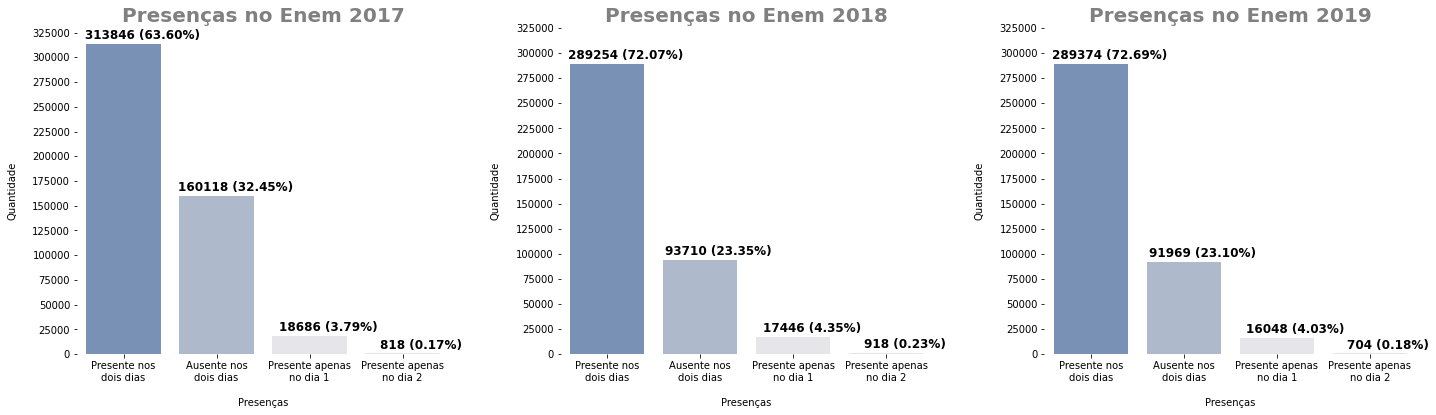

In [174]:
plt.figure(figsize=(24,6))
plt.subplots_adjust(wspace=0.3)
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano, x='PRESENCA_GERAL', order=['11','00','10','01'])
  sns.despine(bottom = True, left = True)
  plt.xticks([0,1,2,3], ['Presente nos\ndois dias', 'Ausente nos\ndois dias', 'Presente apenas\nno dia 1', 'Presente apenas\nno dia 2'])
  plt.yticks(np.arange(0,330000, 25000))
  plt.title('Presenças no Enem {}'.format(int(ano['NU_ANO'].mean())), fontsize=20,  color='grey', fontweight = 'heavy')
  plt.xlabel('Presenças', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=0.2+(p.get_x()+p.get_width()/2.), y=height + 5000, s='{} ({:.2f}%)'.format(height, 100 * height/len(ano)),
                ha="center", fontweight='heavy', fontsize=12)

Observa-se que quando os alunos faltam o primeiro dia de prova raramente eles vão no segundo dia, pois a nota total já se reduz em 3/5 pois são 3 provas.

Vamos isolá-los para observar de forma mais clara.

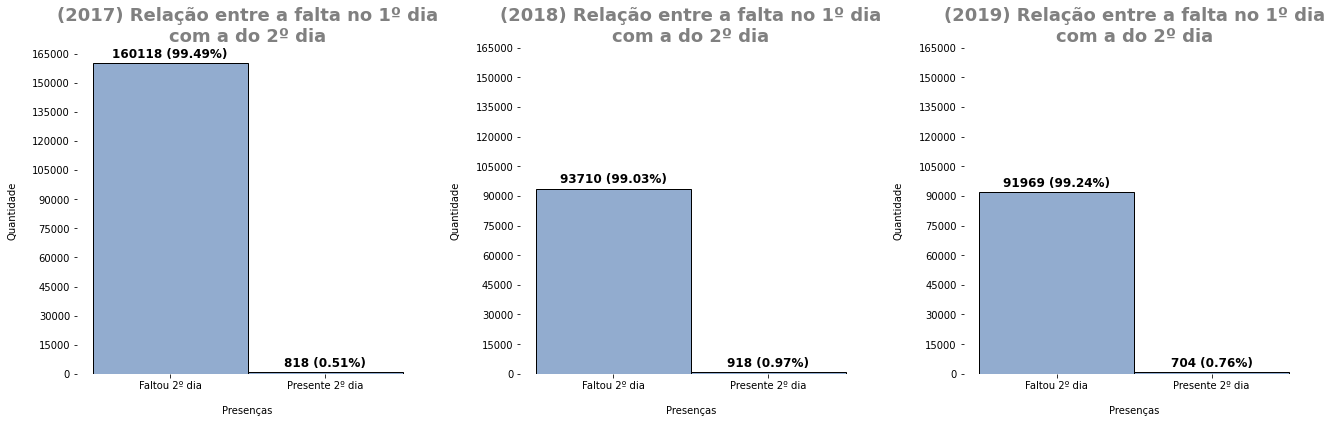

In [175]:
i=1
plt.figure(figsize=(22,6))
plt.subplots_adjust(wspace=0.3)

for ano in lista_de_dataframes:
  plt.subplot(1,3,i) 
  plot = sns.histplot(ano[ano['PRESENCA_DIA_1'] == 0], x='PRESENCA_GERAL')
  sns.despine(bottom = True, left = True)
  plt.title('({}) Relação entre a falta no 1º dia\ncom a do 2º dia'.format(int(ano['NU_ANO'].mean())), fontsize=18, color='grey', fontweight = 'heavy')
  plt.xticks([0,1], ['Faltou 2º dia', 'Presente 2º dia'])
  plt.yticks(np.arange(0,170000, 15000))
  plt.xlabel('Presenças', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
        height = p.get_height()
        plot.text(x=p.get_x()+p.get_width()/2., y=height + 2800, s='{} ({:.2f}%)'.format(height, 100 * height/len(ano[ano['PRESENCA_DIA_1'] == 0])),
                  ha="center", fontweight='heavy', fontsize=12)

Fica mais nítido ainda que ao faltarem no 1º dia de prova, grande maioria (mais do que 99%) já desiste do 2º dia.

#### 3.1.1.2 Relação entre o fator do participante ter veículo (carro ou moto) em casa e as faltas

In [176]:
# Criando a variável para distinguir inscritos que têm ou não veículo

for ano in lista_de_dataframes:
  tem_veiculo = []
  for carro, moto in ano[['Q010','Q011']].values:
    if ((carro == 'A') & (moto == 'A')):
      tem_veiculo.append(0)
    else:
      tem_veiculo.append(1)
    
  ano['TEM_VEICULO'] = tem_veiculo

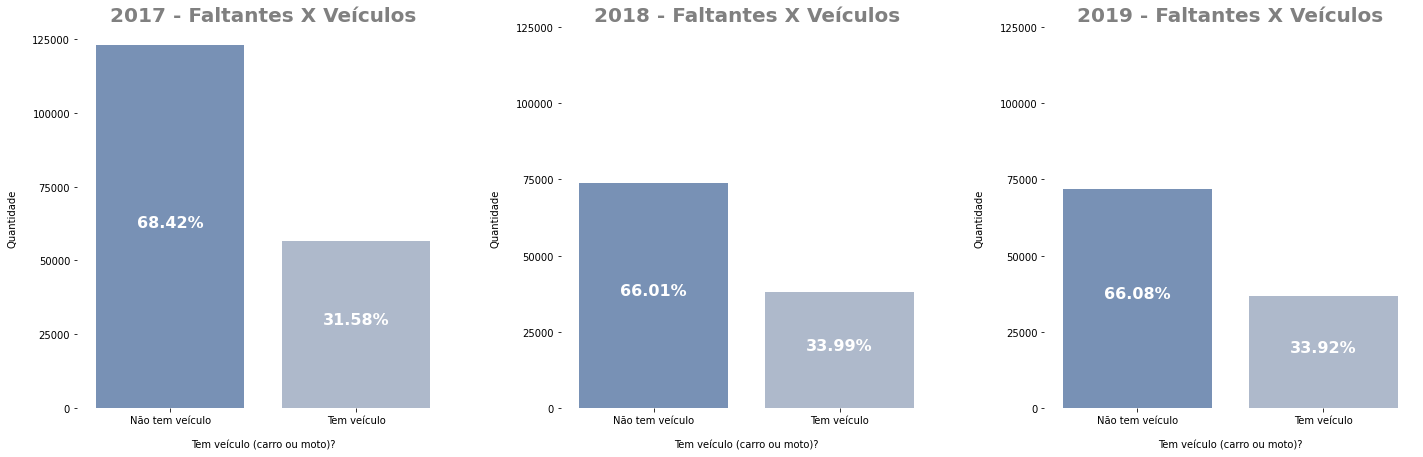

In [177]:
plt.figure(figsize=(24,7))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano[ano['PRESENCA_GERAL'] != '11'], x='TEM_VEICULO')
  sns.despine(bottom = True, left = True)
  plt.xticks([0,1], ['Não tem veículo', 'Tem veículo'])
  plt.yticks(np.arange(0,150000, 25000))
  plt.title('{} - Faltantes X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Tem veículo (carro ou moto)?', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_GERAL'] != '11'])),
                ha="center", color='white', fontweight='heavy', fontsize=16)

Maior parcela das pessoas que faltaram em quaisquer dos dias ou ambos, não tinham veículo (carro ou moto) nas suas casas.

Será que isso ocorreu tanto no 1º quanto no 2º dias do Enem ou a questão discutida acima sobre a relação entre as faltas no 1º dia com as do 2º vai alterar um pouco essa contagem?

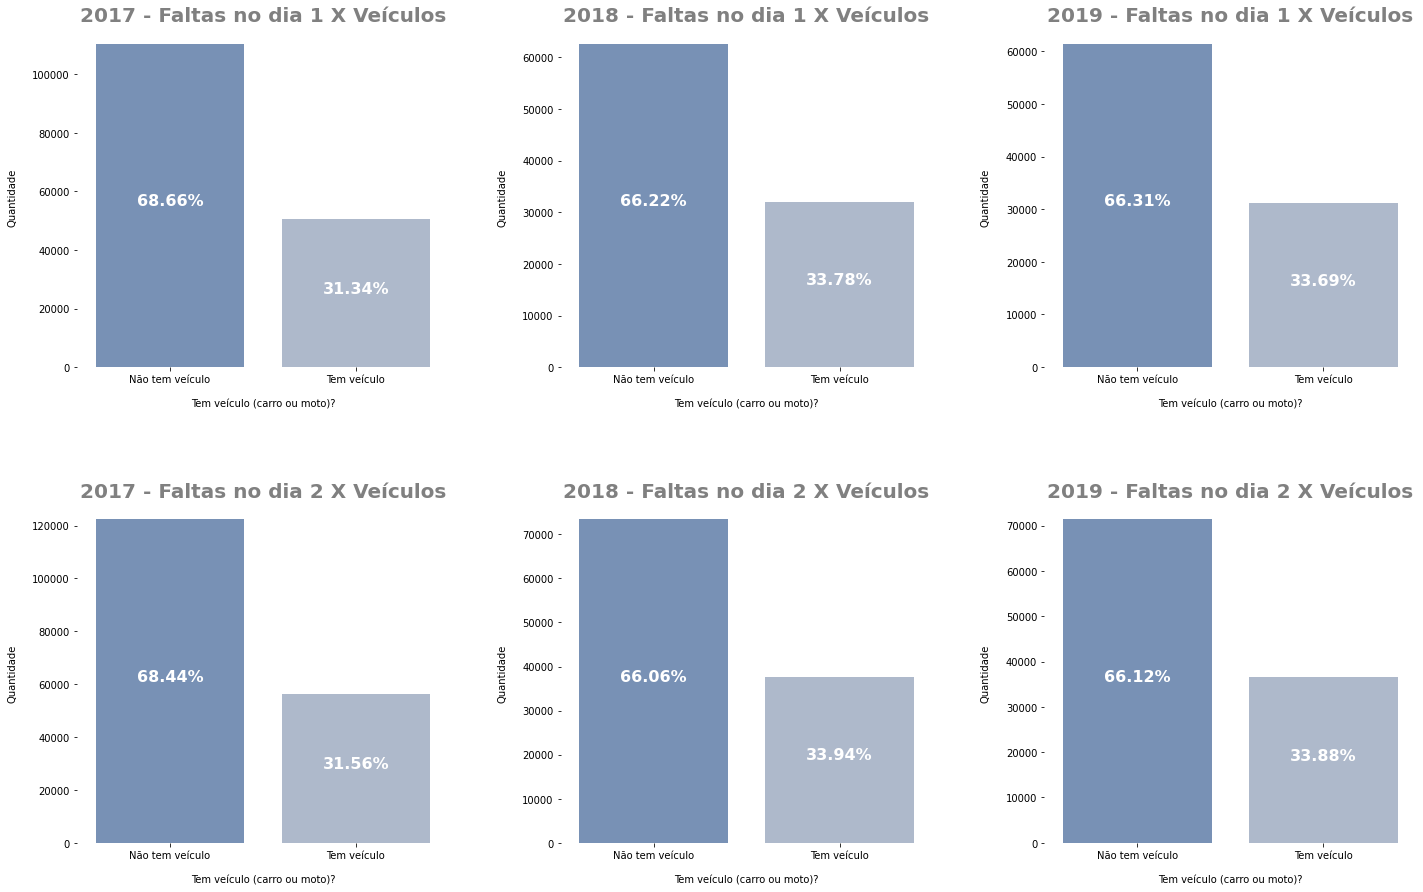

In [178]:
plt.figure(figsize=(24,15))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
i=1

for ano in lista_de_dataframes:
  plt.subplot(2,3,i)
  plot1 = sns.countplot(data=ano[ano['PRESENCA_DIA_1'] == 0], x='TEM_VEICULO', order=[0,1])
  plt.xticks([0,1], ['Não tem veículo', 'Tem veículo'])
  plt.title('{} - Faltas no dia 1 X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Tem veículo (carro ou moto)?', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  for p in plot1.patches:
      height = p.get_height()
      plot1.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_DIA_1'] == 0])),
                 ha="center", color='white', fontweight='heavy', fontsize=16)
  
  plt.subplot(2,3,i+3)
  plot2 = sns.countplot(data=ano[ano['PRESENCA_DIA_2'] == 0], x='TEM_VEICULO', order=[0,1])
  plt.xticks([0,1], ['Não tem veículo', 'Tem veículo'])
  plt.title('{} - Faltas no dia 2 X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Tem veículo (carro ou moto)?', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  for p in plot2.patches:
      height = p.get_height()
      plot2.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_DIA_2'] == 0])),
                 ha="center", color='white', fontweight='heavy', fontsize=16)

  sns.despine(bottom = True, left = True)
  i+=1

O fator dos inscritos terem ou não veículos implica bastante nas faltas, tanto no dia 1 quanto no dia 2 do Enem na Bahia.

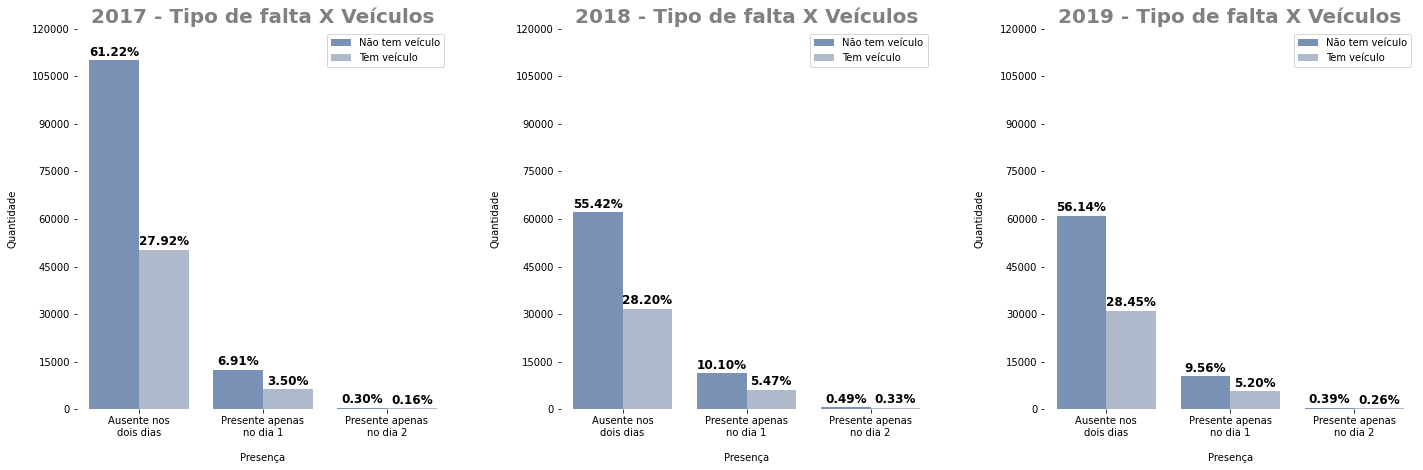

In [179]:
plt.figure(figsize=(24,7))
plt.subplots_adjust(wspace=0.3)
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano[ano['PRESENCA_GERAL'] != '11'], x='PRESENCA_GERAL', hue='TEM_VEICULO', order=['00','10','01'])
  plot.legend(labels=['Não tem veículo', 'Tem veículo'])
  plt.xticks([0,1,2], ['Ausente nos\ndois dias', 'Presente apenas\nno dia 1', 'Presente apenas\nno dia 2'])
  plt.yticks(np.arange(0,130000, 15000))
  plt.title('{} - Tipo de falta X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Presença', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height + 1500, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_GERAL'] != '11'])),
                ha="center", fontweight='heavy', fontsize=12)
      
  sns.despine(bottom = True, left = True)

Observando todos esses gráficos nós podemos perceber que na Bahia a probabilidade de um inscrito que não tem nenhum veículo automotivo em casa faltar no dia da prova é muito maior do que para aqueles que possuem.

Sejam as faltas apenas no 1º dia, apenas no 2º ou em ambos os dias, a maioria delas sempre ocorre com pessoas que não têm nem um carro e nem uma moto em suas casas.

Em todos os anos mais de 55% dos inscritos faltaram nos dois dias e também não possuíam veículos automotivos em casa.

### 3.1.2 Excluindo os inscritos que não foram fazer a prova em nenhum dos dias

Percebemos aqui que há variáveis com muitos valores nulos, teremos que tratar todas elas e primeiramente iremos excluir os valores nulos realcionados aos alunos que faltaram em todas as provas.

In [180]:
for i in lista_de_dataframes:
  print('Tamanho atual do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho atual do DF de 2017: (493468, 74)
Tamanho atual do DF de 2018: (401328, 74)
Tamanho atual do DF de 2019: (398095, 74)


In [181]:
faltas = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC']

enem_ba_2017.drop(enem_ba_2017[enem_ba_2017['PRESENCA_GERAL'] == '00'].index, inplace=True)
enem_ba_2018.drop(enem_ba_2018[enem_ba_2018[faltas].sum(axis=1) == 0].index, inplace=True)
enem_ba_2019.drop(enem_ba_2019[enem_ba_2019[faltas].sum(axis=1) == 0].index, inplace=True)

In [182]:
for i in lista_de_dataframes:
  print('Novo tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Novo tamanho do DF de 2017: (333350, 74)
Novo tamanho do DF de 2018: (307615, 74)
Novo tamanho do DF de 2019: (306126, 74)


## 3.2 Analisando as idades dos participantes do Enem na Bahia

In [183]:
def analise_idade(df):
  plt.subplots_adjust(wspace=0.3)
  sns.boxplot(data=df, x='NU_IDADE')
  plt.xticks(np.arange(0, 105, step=5))
  plt.xlim(0,100)
  plt.title('{}'.format(int(df['NU_ANO'].mode()[0])), fontsize=20, color='grey', fontweight='heavy')
  plt.text(x=0.9, y=0.9, s='Média: {0:.2f}\nMediana: {1:.2f}\nDesvio padrão: {2:.2f}'
  .format(df['NU_IDADE'].mean(), df['NU_IDADE'].median(), df['NU_IDADE'].std()), fontsize=14)
  plt.xlabel('Idade', labelpad = 15)
  plt.tick_params(left=False, bottom=True, labelbottom=True, labelleft=False)
  sns.despine(bottom = True, left = True)

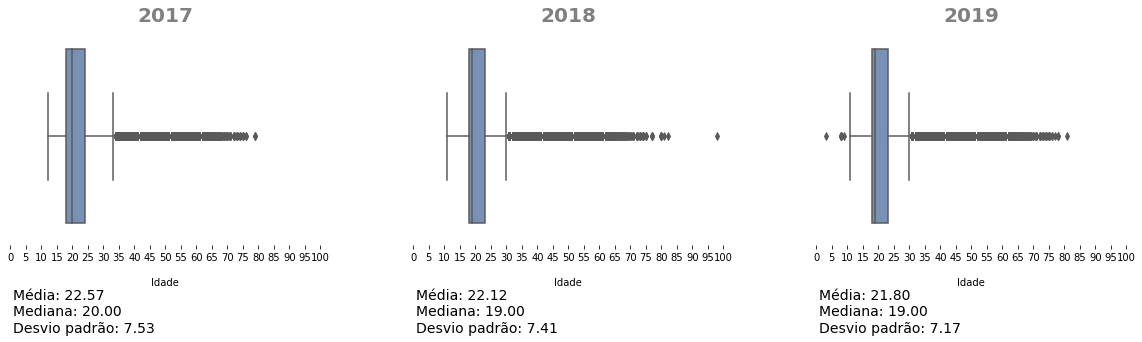

In [184]:
plt.figure(figsize=(20,4))
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  analise_idade(ano)
  i+=1

Percebemos aqui que a média de idade de concorrentes do Enem na Bahia reduziu a cada ano, mas se observarmos o boxplot de 2019 veremos alguns outliers, o que faz com que a média seja puxada pra baixo ou pra cima, o que praticamente não interfere na mediana.

Então, iremos tratar esses dados de idade.

Não existe uma idade mínima para fazer o Enem. Porém, se você estiver no segundo ano do ensino médio ou em alguma série anterior do ensino básico no ano de realização do Exame, terá que fazê-lo como treineiro e não poderá usar a sua nota para se candidatar a uma vaga na Universidade, portanto, iremos excluir todos os registros menores que 15 anos (normalmente alunos do 2º ano tem mais que 15 anos) e que ao mesmo NÃO são treineiros.

In [185]:
for i in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho do DF de 2017: (333350, 74)
Tamanho do DF de 2018: (307615, 74)
Tamanho do DF de 2019: (306126, 74)


In [186]:
for ano in lista_de_dataframes:
  ano.drop(ano[(ano['NU_IDADE'] < 15) & (ano['IN_TREINEIRO'] == 0)].index, inplace=True)

In [187]:
for i in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho do DF de 2017: (333161, 74)
Tamanho do DF de 2018: (307418, 74)
Tamanho do DF de 2019: (305942, 74)


Outra anomalia que podemos encontrar nos nossos dados é que há alguns alunos com menos de 13 anos que já estão no ensino médio, iremos excluí-los também.

In [188]:
# (TP_ST_CONCLUSAO = 3) = Estou cursando e concluirei o Ensino Médio após 2019
# (TP_ST_CONCLUSAO = 2) = Estou cursando e concluirei o Ensino Médio em 2019
# (TP_ST_CONCLUSAO = 1) = Já concluí o Ensino Médio

enem_ba_2019[(enem_ba_2019['NU_IDADE'] < 13) & (enem_ba_2019['TP_ST_CONCLUSAO'] < 4)][['NU_IDADE', 'TP_ST_CONCLUSAO', 'IN_TREINEIRO']]

,NU_IDADE,TP_ST_CONCLUSAO,IN_TREINEIRO
144122,11,3,1
182673,8,3,1
251324,8,3,1
300403,11,3,1


In [189]:
for ano in lista_de_dataframes:
  ano.drop(ano[(ano['NU_IDADE'] < 13) & (ano['TP_ST_CONCLUSAO'] < 4)].index, inplace=True)

In [190]:
for i in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho do DF de 2017: (333161, 74)
Tamanho do DF de 2018: (307418, 74)
Tamanho do DF de 2019: (305938, 74)


Além dos outliers inferiores, que já foram tratados, nós ainda temos outliers superiores, mas nesse caso não iremos tratá-los. Dentro do próprio dicionário dos dados é dito que a coluna 'IN_IDOSO' é declarada no momento da inscrição pelo próprio candidato, dessa forma não temos como observar se a idade mínima pra uma pessoa ser considerada idosa (60 até 2020, segundo o projeto de lei 5383/19) pode coincidindo com a informação da coluna 'IN_IDOSO' nos retornando um valor negando essa condição fazer com que cheguemos à conclusão de que uma pessoa digitou a idade incorretamente, pois se  coluna 'IN_IDOSO' retornar 0, não significa que a pessoa não é idosa e sim que ela não solicitou recursos para atendimento de pessoas idosas, dessa forma, a única coluna que poderíamos utilizar para tratar esse outlier superior se torna inválida para essa análise.

Vamos plotar novamente os boxplots para ver como ficou a nossa distribuição e métricas

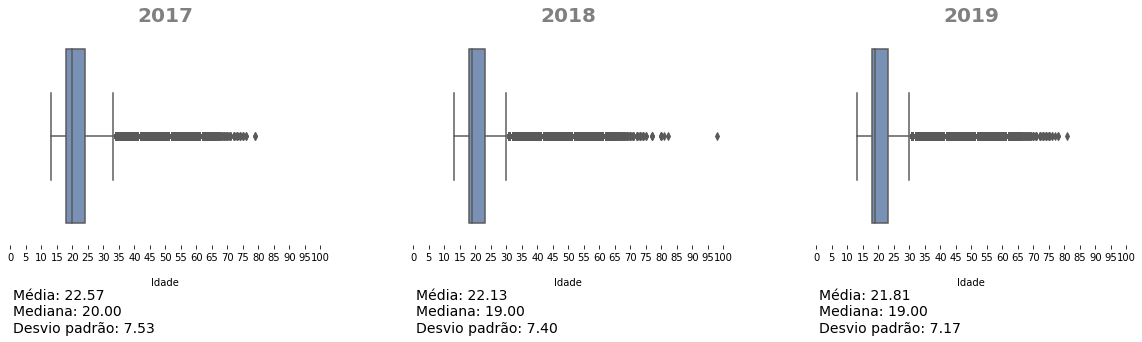

In [191]:
plt.figure(figsize=(20,4))
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  analise_idade(ano)
  i+=1

In [192]:
enem_ba_2017[enem_ba_2017['NU_IDADE'] <= 13][['NU_IDADE', 'IN_TREINEIRO', 'TP_ST_CONCLUSAO']].value_counts()

NU_IDADE  IN_TREINEIRO  TP_ST_CONCLUSAO
13.0      1.0           3.0                11
dtype: int64

In [193]:
enem_ba_2017[enem_ba_2017['NU_IDADE'] <= 14][['NU_IDADE', 'IN_TREINEIRO', 'TP_ST_CONCLUSAO']].value_counts()

NU_IDADE  IN_TREINEIRO  TP_ST_CONCLUSAO
14.0      1.0           3.0                412
13.0      1.0           3.0                 11
dtype: int64

Vejamos que os outliers inferiores desapareceram, ainda temos alunos de 13 anos, mas são todos treineiros e ainda não chegaram no ensino médio.

Podemos perceber também que todos os alunos menores ou iguais a 14 anos estão setados como treineiros (estão no segundo ano do ensino médio ou menos).

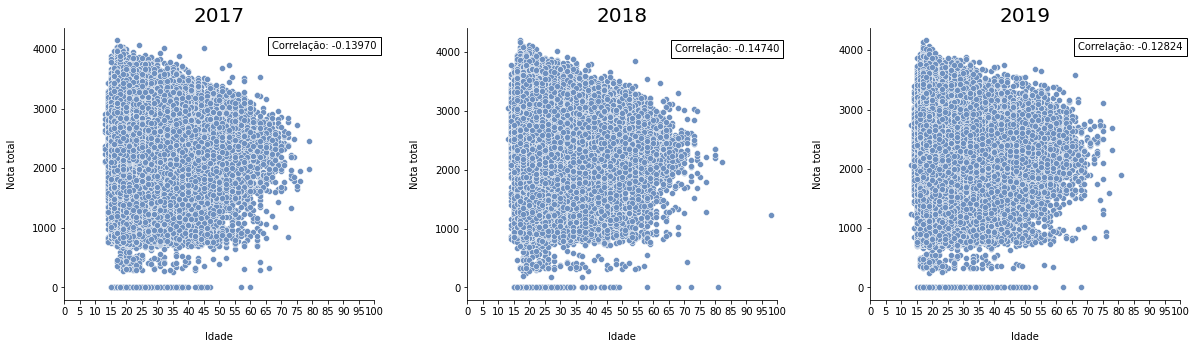

In [194]:
i=1
plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plt.text(x=67, y=4000, s='Correlação: {:.5f}'.format(ano.corr().loc['NU_NOTA_TOTAL','NU_IDADE']), fontsize=10, bbox=dict(facecolor='white'))
  sns.scatterplot(data=ano, x='NU_IDADE', y='NU_NOTA_TOTAL')
  plt.xticks(np.arange(0, 105, step=5))
  plt.xlim(0,100)
  plt.title('{}'.format(int(ano['NU_ANO'].mean())), fontsize=20)
  plt.xlabel('Idade', labelpad = 15)
  plt.ylabel('Nota total', labelpad = 15)
  sns.despine(top = True, right = True)
  i+=1

Podemos observar que a correlação entre essas duas variáveis é ínfima, a idade do participante no Enem na Bahia é pouco ou nada relevante para a sua nota total.

## 3.3 Análise e exclusão de alunos treineiros

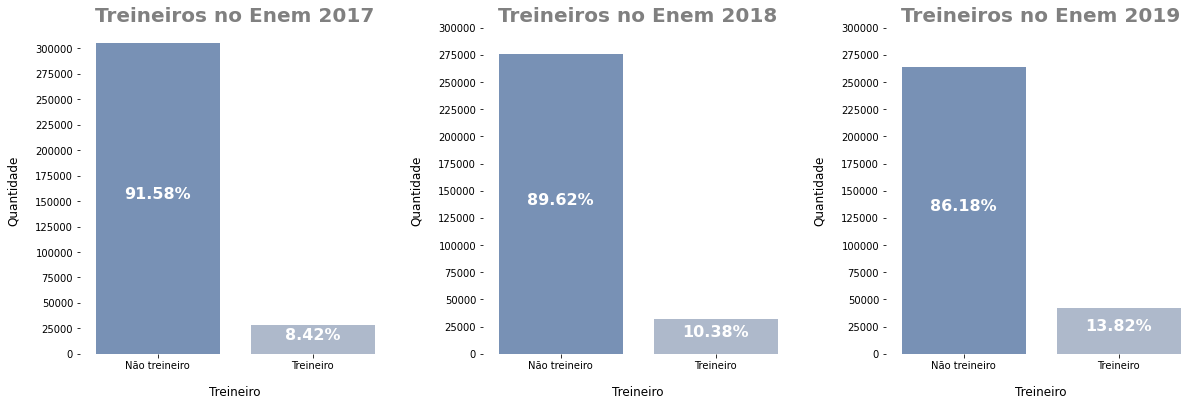

In [195]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano, x='IN_TREINEIRO', order=[0,1])
  plt.title('Treineiros no Enem {}'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Treineiro', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  plt.xticks([0,1], ['Não treineiro', 'Treineiro'])
  plt.yticks(np.arange(0,325000, 25000))
  sns.despine(bottom = True, left = True)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano)),
                ha="center", color='white', fontweight='heavy', fontsize=16)

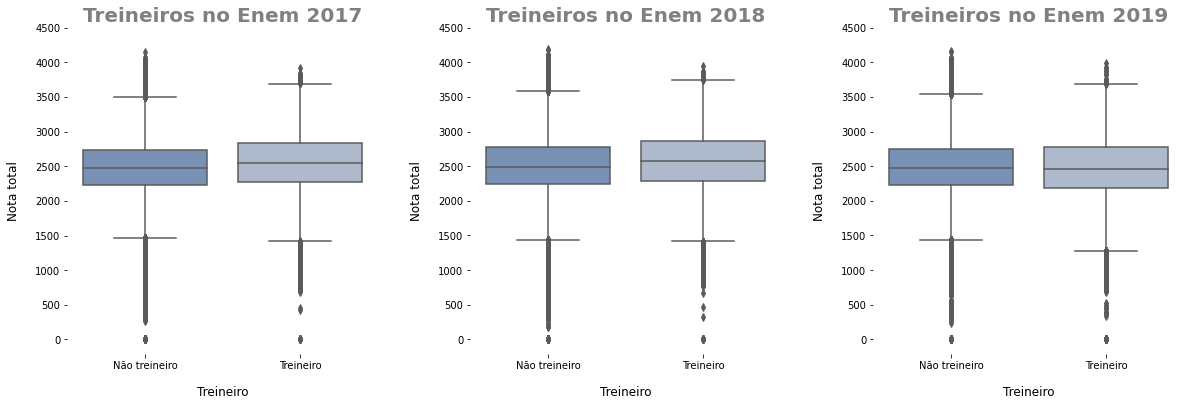

In [196]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=ano, x='IN_TREINEIRO', y='NU_NOTA_TOTAL', order=[0,1])
  plt.title('Treineiros no Enem {}'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Treineiro', labelpad = 15, fontsize=12)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)
  plt.xticks([0,1], ['Não treineiro', 'Treineiro'])
  plt.yticks(np.arange(0,5000,500))
  sns.despine(bottom = True, left = True)
  i+=1

Os treineiros têm uma distribuição de notas melhores do que os não treineiros, o que é surpreendente já que vão fazer a prova apenas por questão de aprendizado, ao contrário dos não treineiros que vão em busca do ingresso no ensino superior. Talvez um dos possíveis motivos para essa distribuição ser mais alta é que a quantidade de não treineiros é muito maior que a de treineiros (durante os 3 anos está entre 6 e 11 vezes maior do que que o número de treineiros).

Dessa forma, iremos excluir todos os alunos que participaram das provas como treineiros, pois iremos realizar análises em cima dos alunos que foram com o intúito de competir por uma vaga no ensino superior e também, como podemos reparar, tanto na análise de treineiros quanto na de idade, essa variável traz alguns dados fora do padrão.

In [197]:
for ano in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(ano['NU_ANO'].mean()), ano.shape))

Tamanho do DF de 2017: (333161, 74)
Tamanho do DF de 2018: (307418, 74)
Tamanho do DF de 2019: (305938, 74)


In [198]:
for ano in lista_de_dataframes:
  ano.drop(ano[ano['IN_TREINEIRO'] == 1].index, inplace=True)

In [199]:
for ano in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(ano['NU_ANO'].mean()), ano.shape))

Tamanho do DF de 2017: (305123, 74)
Tamanho do DF de 2018: (275498, 74)
Tamanho do DF de 2019: (263644, 74)


## 3.4 Relação entre a cor/raça do participante com as suas notas

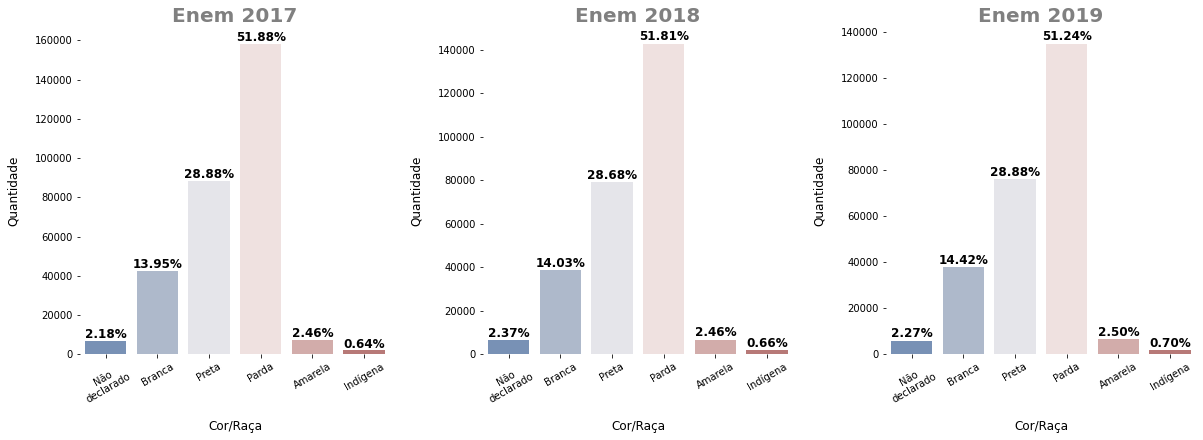

In [200]:
plt.figure(figsize=(20,6))
i=1

for ano in lista_de_dataframes:
  plt.subplots_adjust(wspace=0.3)
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano, x='TP_COR_RACA')
  plt.title('Enem {}'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xticks([0,1,2,3,4,5], ['Não\ndeclarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'], rotation=30)
  plt.xlabel('Cor/Raça', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height + 1500, s='{:.2f}%'.format(100 * height/len(ano)),
                ha="center", fontweight='heavy', fontsize=12)
      
  i+=1

Pardos ou pretos são aproximadamente 80% de todos os participantes do Enem na Bahia nos 3 anos.

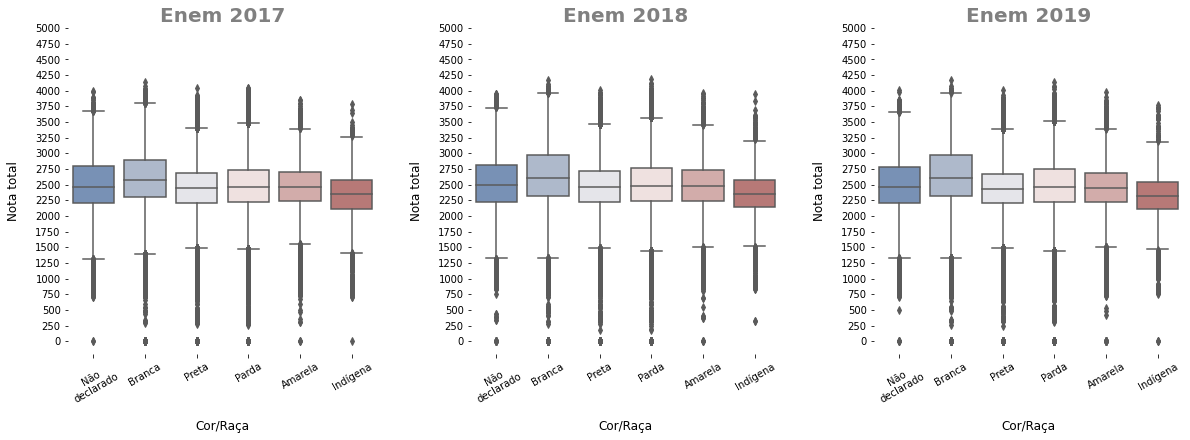

In [201]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for df in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=df, x='TP_COR_RACA', y='NU_NOTA_TOTAL')
  plt.title('Enem {}'.format(int(df['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xticks([0,1,2,3,4,5], ['Não\ndeclarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'], rotation=30)
  plt.yticks(np.arange(0,5250,250))
  plt.xlabel('Cor/Raça', labelpad = 15, fontsize=12)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

Apesar de pretos e pardos representarem aproximadamente 80% dos participantes do Enem na Bahia, as pessoas de cor autodeclarada branca tendem a ter notas mais altas do que as demais, isso ainda é reflexo da era da escravidão no país (pardos também sofrem com isso devido à missigenação), visto que as pessoas que são descendentes dos humanos escravizados na época, maior parte formadora das favelas e morros brasileiros, ainda têm dificuldade de inserirem-se na sociedade de forma igualitária, tem também a dificuldade de acesso ao ensino para os indígenas, o que faz com que esse grupo tenha muita dificuldade nessa prova (tem os menores 3º quartis em todos os anos, aproximadamente 75% das notas ficam abaixo).

<b>Isso tudo só reforça que SIM, as cotas para ingresso em Universidades no Brasil ainda são MUITO necessárias.<b>

## 3.5 O sexo influencia nas notas do Enem Baiano?

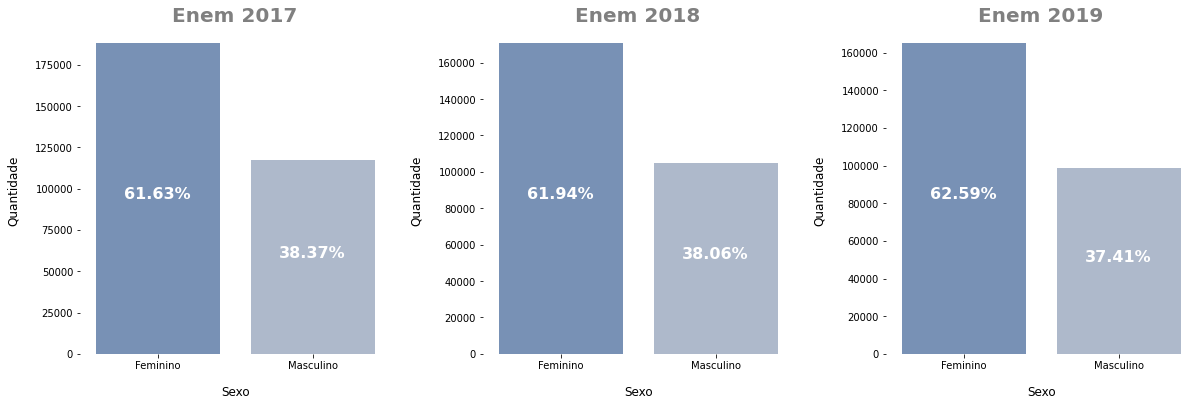

In [202]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano, x='TP_SEXO', order=['F','M'])
  plt.title('Enem {}'.format(2016+i), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Sexo', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  plt.xticks([0,1], ['Feminino', 'Masculino'])
  sns.despine(bottom = True, left = True)
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano)),
                ha="center", color='white', fontweight='heavy', fontsize=16)
  
  i+=1

Como podemos ver aqui, maioria do público do Enem é feminino em todos os anos.

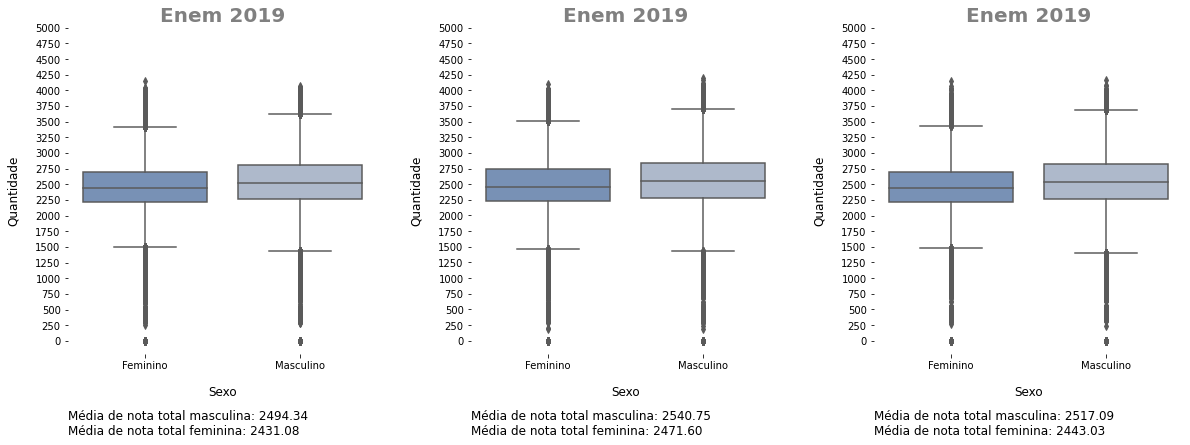

In [203]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=ano, x='TP_SEXO', y='NU_NOTA_TOTAL', order=['F','M'])
  plt.title('Enem {}'.format(int(df['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Sexo', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  plt.yticks(np.arange(0,5250,250))
  plt.xticks([0,1], ['Feminino', 'Masculino'])
  sns.despine(bottom = True, left = True)
  plt.text(x=-0.5, y=-1500, fontsize=12, s='Média de nota total masculina: {:.2f}\nMédia de nota total feminina: {:.2f}'
  .format(ano[ano['TP_SEXO'] == 'M']['NU_NOTA_TOTAL'].mean(), ano[ano['TP_SEXO'] == 'F']['NU_NOTA_TOTAL'].mean()))
  i+=1

As notas dos participantes masculinos parecem ser maiores que as femininas, em todos os anos temos cerca de 60 a 70 pontos de diferença, não tem como definir apenas por essas métricas que o sexo é impactante na nota, principalmente pois se observarmos os gráficos de boxplot, veremos que a grande maioria dos outliers são inferiores e como os participantes do sexo feminino são a maioria, esses outliers tendem a puxar as medidas para baixo. Portanto, definiremos que o sexo tem pouca ou nenhuma relevância sobre as notas totais.

## 3.6 Atendimento especializado e específico

In [204]:
pedidos = ['IN_ATENDIMENTO_ESPECIALIZADO', 'IN_ATENDIMENTO_ESPECIFICO']
print('RELATÓRIO DE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO')

for pedido in pedidos:
  print('\n---------------------------------\n{} == 1\n'.format(pedido),'---------------------------------')
  for ano in lista_de_dataframes:
    print('({0}) Qntd bruta: {1}'
    .format(int(ano['NU_ANO'].mean()), (ano[pedido].value_counts()[1])))
    print('({0}) Porcentagem: {1:.2f}%'
    .format(int(ano['NU_ANO'].mean()), (ano[pedido].value_counts()[1]/len(ano))*100),'\n')

RELATÓRIO DE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO

---------------------------------
IN_ATENDIMENTO_ESPECIALIZADO == 1
 ---------------------------------
(2017) Qntd bruta: 1579
(2017) Porcentagem: 0.52% 

(2018) Qntd bruta: 1322
(2018) Porcentagem: 0.48% 

(2019) Qntd bruta: 1416
(2019) Porcentagem: 0.54% 


---------------------------------
IN_ATENDIMENTO_ESPECIFICO == 1
 ---------------------------------
(2017) Qntd bruta: 321
(2017) Porcentagem: 0.11% 

(2018) Qntd bruta: 220
(2018) Porcentagem: 0.08% 

(2019) Qntd bruta: 195
(2019) Porcentagem: 0.07% 



In [205]:
print('RELATÓRIO DE CORRELAÇÃO ENTRE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO E A NOTA FINAL')

for ano in lista_de_dataframes:
  print('\n')
  for pedido in pedidos:
    print('({0}) Correlação entre {1} e a nota total: {2:.4f}'.format(int(ano['NU_ANO'].mean()), pedido, ano[[pedido, 'NU_NOTA_TOTAL']].corr().iloc[:,1][0]))

RELATÓRIO DE CORRELAÇÃO ENTRE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO E A NOTA FINAL


(2017) Correlação entre IN_ATENDIMENTO_ESPECIALIZADO e a nota total: -0.0152
(2017) Correlação entre IN_ATENDIMENTO_ESPECIFICO e a nota total: -0.0069


(2018) Correlação entre IN_ATENDIMENTO_ESPECIALIZADO e a nota total: -0.0065
(2018) Correlação entre IN_ATENDIMENTO_ESPECIFICO e a nota total: -0.0092


(2019) Correlação entre IN_ATENDIMENTO_ESPECIALIZADO e a nota total: -0.0087
(2019) Correlação entre IN_ATENDIMENTO_ESPECIFICO e a nota total: -0.0033


Podemos observar que a quantidade de pessoas que possuem essas características é muito pequena, além de em todos os anos possuírem uma correlação muito baixa com a nota total, dessa forma principalmente pela pouquíssima quantidade de dados representando esses tipos de atendimentos não podemos tirar nenhuma conclusão sobre essas características.

# 4. Análise de características sociais

## 4.1 Impacto da Renda familiar (Q006) nas notas totais

Dicionário dos dados de renda:<br><br>
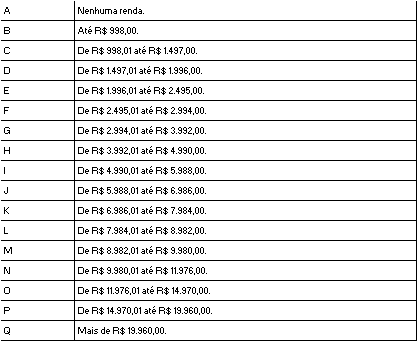

In [206]:
def box_impacto(df, x):
  sns.boxplot(data=df, x=x, y='NU_NOTA_TOTAL', hue='NU_ANO', order=sorted(df[x].unique()), hue_order=[2017,2018,2019])
  sns.despine(bottom = True, left = True)
  plt.grid(False)
  plt.legend(loc='lower right')
  plt.ylabel('Nota total', labelpad=15, fontsize=12)

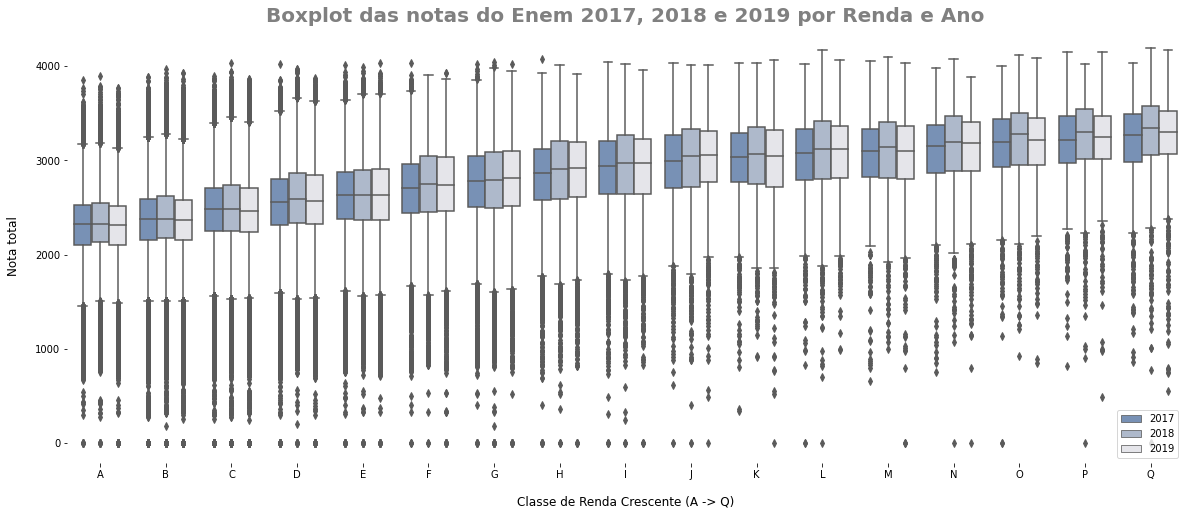

In [207]:
plt.figure(figsize=(20,8))
plt.title('Boxplot das notas do Enem 2017, 2018 e 2019 por Renda e Ano', fontsize=20, color='grey', fontweight='heavy')
box_impacto(pd.concat(lista_de_dataframes), 'Q006')
plt.xlabel('Classe de Renda Crescente (A -> Q)', labelpad = 15, fontsize=12)
plt.show()

Podemos observar que em todos os anos, sem exceção, as notas infelizmente são muito impactadas pela renda familiar de cada participante da prova do Enem, isso deve-se a diversos fatores sociais presentes no nosso país e escancara ainda mais a distância entre ricos e pobres no Brasil.

## 4.2 Impacto da formação do pai e da mãe

Dicionário das formações tanto de pai quanto de mãe do participante:<br>
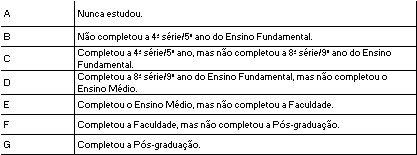

### 4.2.1 Impacto da formação do pai na nota total do Enem na Bahia

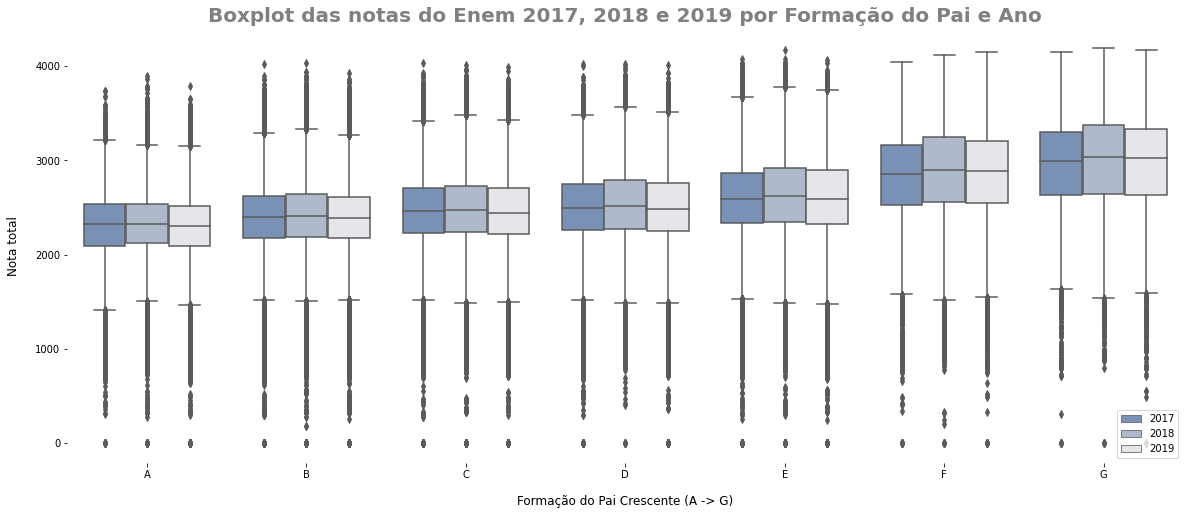

In [208]:
# Iremos tirar os valores H da coluna 'Q001' pois significam a resposta 'Não sei'
plt.figure(figsize=(20,8))
plt.title('Boxplot das notas do Enem 2017, 2018 e 2019 por Formação do Pai e Ano', fontsize=20, color='grey', fontweight='heavy')
box_impacto(pd.concat(lista_de_dataframes)[pd.concat(lista_de_dataframes)['Q001'] != 'H'], 'Q001')
plt.xlabel('Formação do Pai Crescente (A -> G)', labelpad=15, fontsize=12)
plt.show()

### 4.2.2 Impacto da formação da mãe na nota total do Enem na Bahia

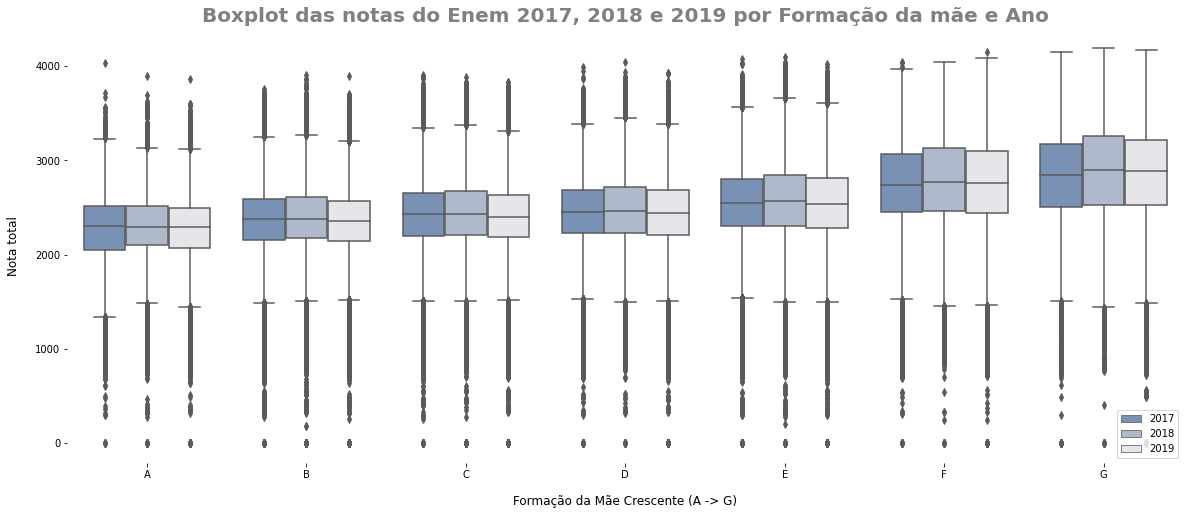

In [209]:
# Iremos tirar os valores H da coluna 'Q001' pois significam a resposta 'Não sei'
plt.figure(figsize=(20,8))
plt.title('Boxplot das notas do Enem 2017, 2018 e 2019 por Formação da mãe e Ano', fontsize=20, color='grey', fontweight='heavy')
box_impacto(pd.concat(lista_de_dataframes)[pd.concat(lista_de_dataframes)['Q002'] != 'H'], 'Q002')
plt.xlabel('Formação da Mãe Crescente (A -> G)', labelpad=15, fontsize=12)
plt.show()

Da mesma forma que vimos a renda familiar influenciando bastante na nota total dos alunos, podemos observar também analisando a formação de seus pais, mais uma prova do reflexo da desigualdade social no Brasil.

## 4.3 Tipo de escola do ensino médio

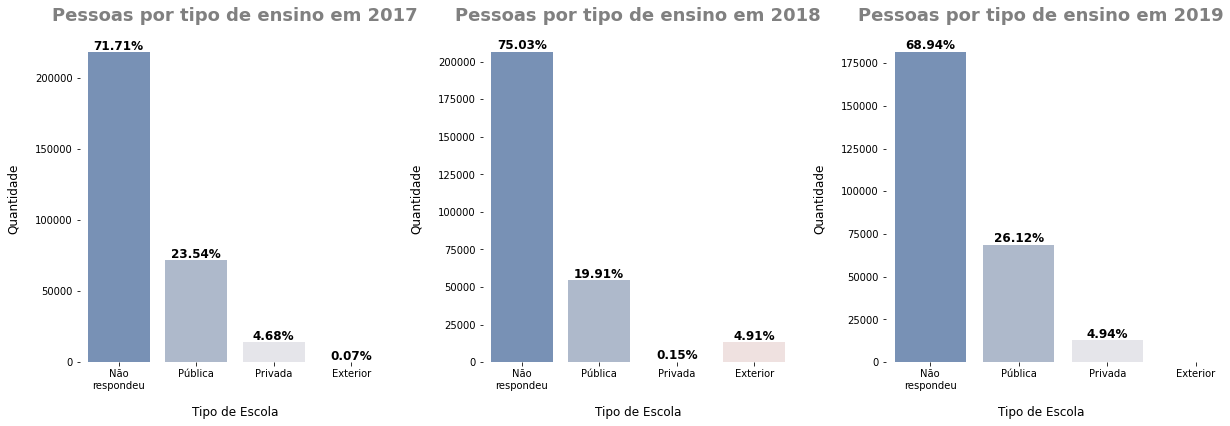

In [210]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano, x='TP_ESCOLA')
  plt.title('Pessoas por tipo de ensino em {}'.format(int(ano['NU_ANO'].mean())), fontsize=18, color='grey', fontweight='heavy', pad=15)
  plt.xticks([0,1,2,3], ['Não\nrespondeu', 'Pública', 'Privada', 'Exterior'])
  plt.xlabel('Tipo de Escola', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height + 1500, s='{:.2f}%'.format(100 * height/len(ano)),
                ha="center", fontweight='heavy', fontsize=12)
  i+=1

A maior parte dos participantes não responderam, mas dos que responderam, durante os 3 anos a escola pública tem muito mais participantes do que nas privadas e exteriores.

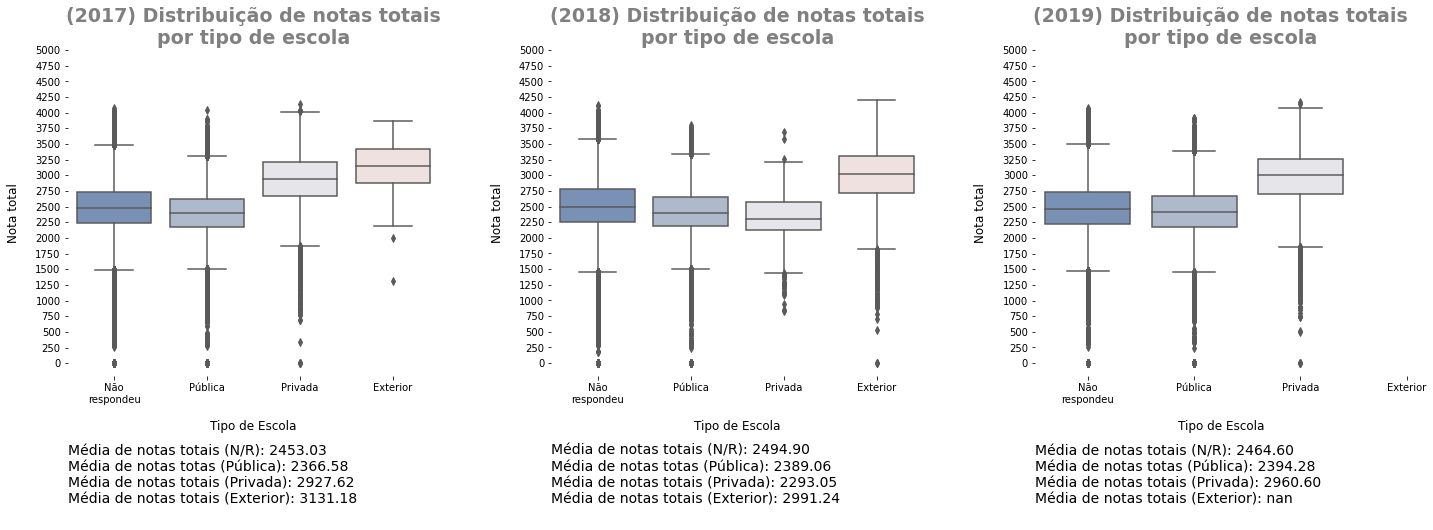

In [211]:
plt.figure(figsize=(24,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=ano, x='TP_ESCOLA', y='NU_NOTA_TOTAL')
  plt.title('({}) Distribuição de notas totais\npor tipo de escola'.format(int(ano['NU_ANO'].mean())), fontsize=19, color='grey', fontweight='heavy')
  plt.xticks([0,1,2,3], ['Não\nrespondeu', 'Pública', 'Privada', 'Exterior'])
  plt.yticks(np.arange(0,5250,250))
  plt.text(x=-0.5, y=-2500, fontsize=14, s='Média de notas totais (N/R): {:.2f}\nMédia de notas totas (Pública): {:.2f}\nMédia de notas totais (Privada): {:.2f}\nMédia de notas totais (Exterior): {:.2f}\n'
  .format(ano[ano['TP_ESCOLA'] == 1]['NU_NOTA_TOTAL'].mean(), ano[ano['TP_ESCOLA'] == 2]['NU_NOTA_TOTAL'].mean(),
          ano[ano['TP_ESCOLA'] == 3]['NU_NOTA_TOTAL'].mean(), ano[ano['TP_ESCOLA'] == 4]['NU_NOTA_TOTAL'].mean()))
  plt.xlabel('Tipo de Escola', labelpad = 15, fontsize=12)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

Uma curiosidade é que o ano de 2018 é o único no qual temos a média e a distribuição de notas totais do ensino público sendo superior à do ensino privado, mas acontece que isso torna pouco conclusivo pois como foi dito anteriormente, a quantidade de alunos que não responderam é muito alta, portanto essa característica é pouco relevante para o estudo.

## 4.4 Qual o impacto do fator de um participante não ter internet, celular e/ou computador em casa na nota total?

In [212]:
# Transformando as colunas que informam sobre o participante ter um ou mais celular em casa e ter um ou mais computadores em casa
# em apenas uma coluna que indica se eles têm ao menos 1 celular ou 1 computador em casa

for df in lista_de_dataframes:
  df['PC_CELULAR'] = ((df['Q022'] != 'A') | (df['Q024'] != 'A')).values
  df['PC_CELULAR'] = df['PC_CELULAR'].apply(lambda x: 'B' if x else 'A')

In [213]:
for df in lista_de_dataframes:
  df['TEM_COMO_ESTUDAR'] = ((df['Q025'] == 'A') | (df['PC_CELULAR'] == 'A')).values # NÃO TEM NET OU CEL_PC
  df['TEM_COMO_ESTUDAR'] = df['TEM_COMO_ESTUDAR'].apply(lambda x: 'A' if x else 'B') # RETORNA B CASO TENHA OU 1 OU NENHUM DOS DOIS, RETORNA A QUANDO TEM OS DOIS

In [214]:
def box_tem_como_estudar(df):
  plt.subplots_adjust(wspace=0.3)
  sns.despine(bottom = True, left = True)
  sns.boxplot(data=df, x='TEM_COMO_ESTUDAR', y='NU_NOTA_TOTAL')
  plt.title('Teve como estudar em casa (Enem {})?'.format(int(df['NU_ANO'].mean())), fontsize=12, color='grey', fontweight='heavy')
  plt.xticks(ticks=[0,1], labels=['Teve', 'Não teve'])
  plt.xlabel('Teve Acesso a Estudo Virtual em Casa', labelpad = 15, fontsize=10)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)

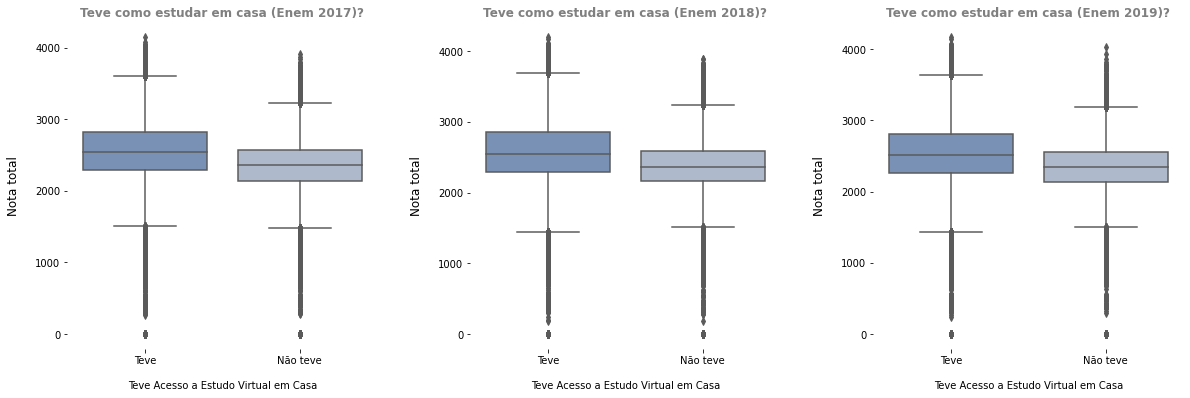

In [215]:
plt.figure(figsize=(20,6))
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  box_tem_como_estudar(ano)
  i+=1

O fato de um participante:


*   Não ter internet nem celular ou computador em casa
*   Ter internet mas não ter celular ou computador em casa
*   Ter celular ou computador em casa mas não ter internet

Fazem com que o participante não tenha como estudar, portanto, é bem plausível que a sua nota total seja inferior aos alunos que possuem esses benefícios, como mostrado nos gráficos acima.



# 5. Análise de características localizacionais

## 5.1 Baixando arquivos do IBGE e extraíndo-os

In [216]:
municipios_url = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/BA/ba_municipios.zip'
wget.download(municipios_url, '/content/drive/My Drive/Dados_IBGE_Para_Mapa_da_Bahia/ba_municipios.zip')

'/content/drive/My Drive/Dados_IBGE_Para_Mapa_da_Bahia/ba_municipios (1).zip'

In [217]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/Dados_IBGE_Para_Mapa_da_Bahia/ba_municipios.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/Dados_IBGE_Para_Mapa_da_Bahia/ba_municipios')

In [218]:
municipios = gpd.read_file('/content/drive/My Drive/Dados_IBGE_Para_Mapa_da_Bahia/ba_municipios/BA_Municipios_2019.shp')

## 5.2 Distribuição de participantes por Município em que reside

In [219]:
municipios = municipios.sort_values(by='NM_MUN').reset_index(drop=True)

In [220]:
municipios['participantes_2017'] = enem_ba_2017.groupby(by='NO_MUNICIPIO_RESIDENCIA', sort=True).count()['NU_ANO'].values
municipios['participantes_2018'] = enem_ba_2018.groupby(by='NO_MUNICIPIO_RESIDENCIA', sort=True).count()['NU_ANO'].values
municipios['participantes_2019'] = enem_ba_2019.groupby(by='NO_MUNICIPIO_RESIDENCIA', sort=True).count()['NU_ANO'].values

soma_2017 = enem_ba_2017.groupby(by='NO_MUNICIPIO_RESIDENCIA', sort=True).sum()['NU_NOTA_TOTAL'].values
soma_2018 = enem_ba_2018.groupby(by='NO_MUNICIPIO_RESIDENCIA', sort=True).sum()['NU_NOTA_TOTAL'].values
soma_2019 = enem_ba_2019.groupby(by='NO_MUNICIPIO_RESIDENCIA', sort=True).sum()['NU_NOTA_TOTAL'].values

municipios['media_2017'] = soma_2017/municipios['participantes_2017']
municipios['media_2018'] = soma_2018/municipios['participantes_2018']
municipios['media_2019'] = soma_2019/municipios['participantes_2019']

municipios['%participantes_2017'] = municipios['participantes_2017']/len(enem_ba_2017)
municipios['%participantes_2018'] = municipios['participantes_2017']/len(enem_ba_2017)
municipios['%participantes_2019'] = municipios['participantes_2017']/len(enem_ba_2017)

Quer visualizar o gráfico de mapa com o percentual de participantes de qual ano?
2019


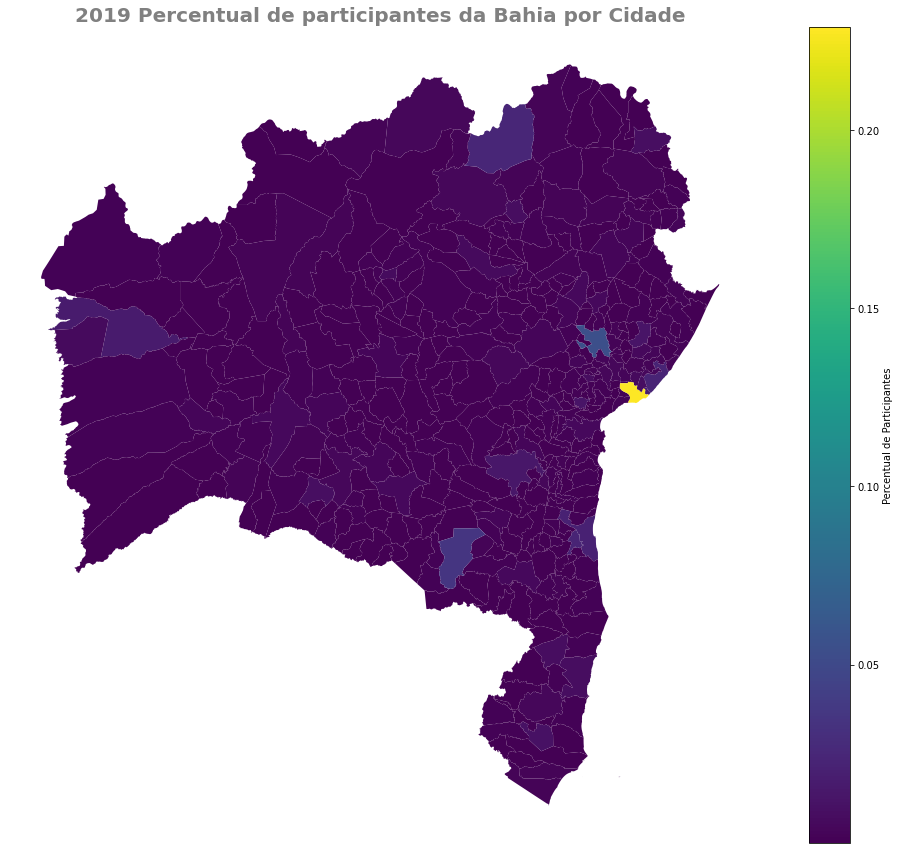

In [221]:
ano = input('Quer visualizar o gráfico de mapa com o percentual de participantes de qual ano?\n')

municipios.plot(figsize=(20,15),column='%participantes_{}'.format(ano), legend=True, legend_kwds={'label': "Percentual de Participantes",'orientation': "vertical"})
plt.title('{} Percentual de participantes da Bahia por Cidade'.format(ano), fontsize=20, color='grey', fontweight='heavy')
plt.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
sns.despine(bottom = True, left = True)

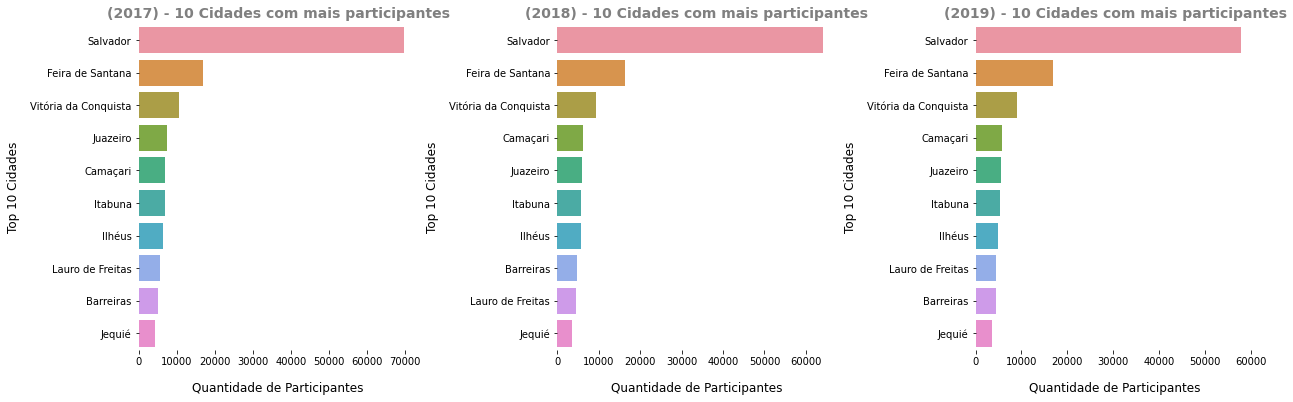

In [222]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.5)
i=1

for ano in ['participantes_2017', 'participantes_2018', 'participantes_2019']:
  plt.subplot(1,3,i)
  sns.barplot(data=municipios[['NM_MUN', ano]].sort_values(ano, ascending=False).head(10), x=ano, y='NM_MUN')
  plt.title('({}) - 10 Cidades com mais participantes'.format(ano[14:]), fontsize=14, color='grey', fontweight='heavy')
  plt.xlabel('Quantidade de Participantes', labelpad = 15, fontsize=12)
  plt.ylabel('Top 10 Cidades', labelpad = 10, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

Como já era esperado, a cidade com maior número de participantes em todos os 3 anos é Salvador, seguida de Feira de Santana, pois são as duas cidades mais populosas do estado da Bahia, mas será que a média das notas totais dessas duas cidades também são as maiores?

Quer visualizar o gráfico de mapa com médias das notas totais de qual ano?
2019


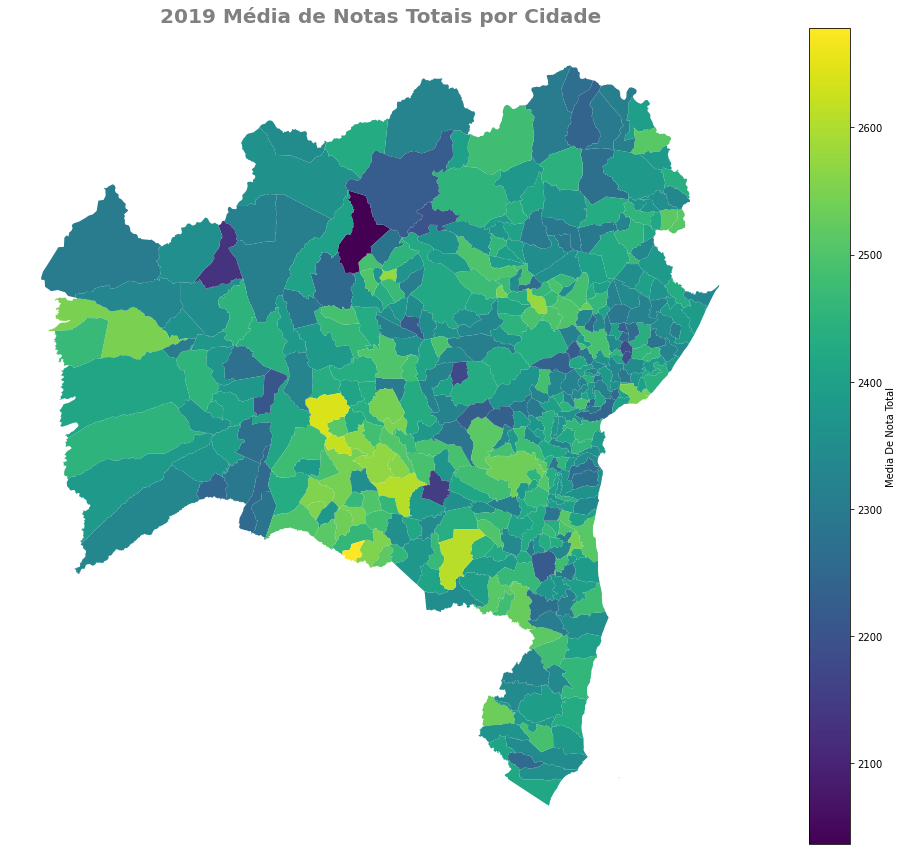

In [223]:
ano = input('Quer visualizar o gráfico de mapa com médias das notas totais de qual ano?\n')

grafico = municipios.plot(figsize=(20,15),column='media_{}'.format(ano), legend=True, legend_kwds={'label': "Media De Nota Total",'orientation': "vertical"})
plt.title('{} Média de Notas Totais por Cidade'.format(ano), fontsize=20, color='grey', fontweight='heavy')
plt.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
sns.despine(bottom = True, left = True)

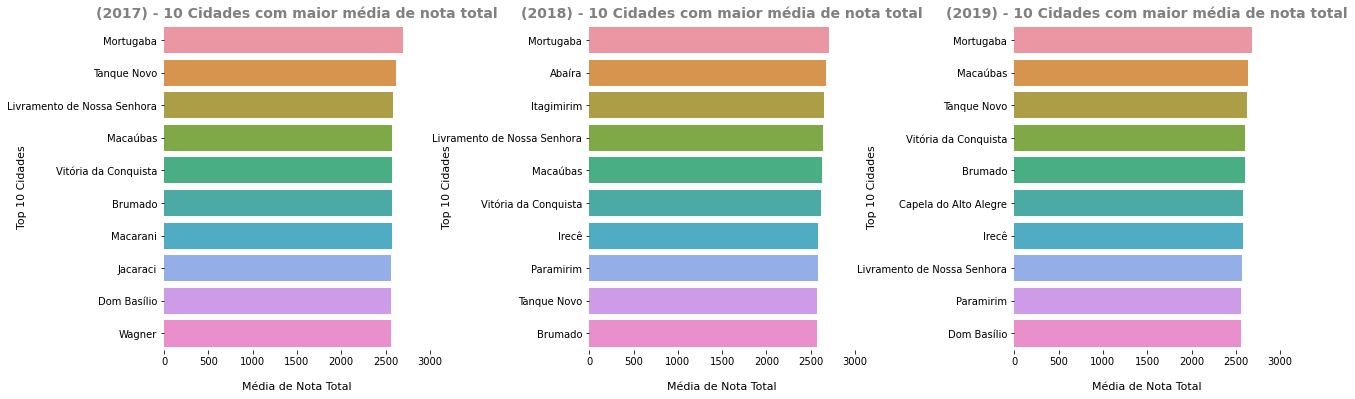

In [224]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.6)
i=1

for ano in ['media_2017', 'media_2018', 'media_2019']:
  plt.subplot(1,3,i)
  sns.barplot(data=municipios[['NM_MUN', ano]].sort_values(ano, ascending=False).head(10), x=ano, y='NM_MUN')
  plt.title('({}) - 10 Cidades com maior média de nota total'.format(ano[6:]), fontsize=14, color='grey', fontweight='heavy')
  plt.xlabel('Média de Nota Total', labelpad = 15, fontsize=11)
  plt.ylabel('Top 10 Cidades', labelpad = -20, fontsize=11)
  plt.xticks(np.arange(0,3500,500))
  sns.despine(bottom = True, left = True)
  i+=1

Podemos observar que não, nem Salvador e nem Feira de Santana aparecem entre as maiores médias de nota total do Enem.

# 6. Análise destrinchada sobre as notas

<h3><b>Informação (REPETIDA):</b> As ordens das provas por dia em ambos os anos foram...</h3>

<b>1º Dia</b>

– Linguagens, Códigos e suas Tecnologias: Língua Portuguesa; Literatura; Língua Estrangeira – Inglês ou Espanhol; Artes; Educação Física; Tecnologias da Informação e Comunicação.

– Ciências Humanas e suas Tecnologias: História; Geografia; Filosofia; Sociologia.

– Redação

<b>2º Dia</b>

– Ciências da Natureza e suas Tecnologias: Química; Física; Biologia.

– Matemática e suas tecnologias: Matemática.

## 6.1 Analisando as notas e suas distribuições

In [225]:
notas = ['NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL']

In [226]:
# Plota o histograma da nota passada por parâmetro
def hist_nota(df, coluna):
  plt.subplots_adjust(wspace=0.3, hspace=0.5)
  if df[coluna].nunique() > 100:
    sns.histplot(data=df, x=coluna, kde=True, stat='count')
    if (df[coluna].max() > 1000):
      plt.xticks(np.arange(-500, 5500, step=500))
      plt.xlim(-10,5000)
    else:
      plt.xticks(np.arange(-100, 1100, step=100))
      plt.xlim(-10,1000)

    plt.yticks(np.arange(0, 7500, step=500))
    plt.ylim(0,7000)
    plt.axvline(x=df[coluna].mean(), label='Média: {0:.2f}'.format(df[coluna].mean()), color='r', alpha=1)
    plt.axvline(x=df[coluna].median(), label='Mediana: {0:.2f}'.format(df[coluna].median()), color='g', alpha=1)
    plt.legend()
  else:
    sns.histplot(data=df, x=coluna, kde=True, stat='count', bins=df[coluna].nunique())
    plt.xticks(np.arange(-100, 1100, step=100))
    plt.xlim(-10,1000)
    plt.yticks(np.arange(0, 30001, step=5000))
    plt.ylim(0,30000)
    plt.axvline(x=df[coluna].mean(), label='Média: {0:.2f}'.format(df[coluna].mean()), color='r', alpha=1)
    plt.axvline(x=df[coluna].median(), label='Mediana: {0:.2f}'.format(df[coluna].median()), color='g', alpha=1)
    plt.legend()

# Plota o boxplot da nota passada por parâmetro
def box_nota(df, coluna):
  sns.boxplot(data=df, y=coluna)
  plt.text(x=0.1, y=-100, s='Desvio padrão: {0:.2f}'.format(df[coluna].std()), fontsize=10)
  if (df[coluna].max() > 1000):
    plt.yticks(np.arange(-500, 5500, step=500))
    plt.ylim(-200,5200)
  else:
    plt.yticks(np.arange(-100, 1100, step=100))
    plt.ylim(-50,1050)
    

# Faz o plot total
def grid_nota(nota):
  plt.figure(figsize=(20,12))
  i=1

  for ano in lista_de_dataframes:
    nome_prova = nota[3:].split('_')[1]

    if nome_prova == 'TOTAL':
      nome_prova = nome_prova.capitalize()
    elif nome_prova == 'MT':
      nome_prova = 'de Matemática'
    elif nome_prova == 'CN':
      nome_prova = 'de C. Naturais'
    elif nome_prova == 'CH':
      nome_prova = 'de C. Humanas'
    elif nome_prova == 'LC':
      nome_prova = 'de L. e Códigos'
    else:
      nome_prova = 'de Redação'

    titulo = 'Nota '+nome_prova+' em '+str(int(ano['NU_ANO'].mean()))

    plt.subplot(2,3,i)
    hist_nota(ano, nota)
    plt.title('Histograma de '+titulo, fontsize=14, color='grey', fontweight='heavy', pad=10)

    plt.subplot(2,3,i+3)
    box_nota(ano, nota)
    plt.ylabel('Quantidade', labelpad = 15)
    plt.title('Boxplot de '+titulo, fontsize=14, color='grey', fontweight='heavy', pad=10)

    sns.despine(bottom = True, left = True)
    i+=1

### 6.1.1 Nota total (soma de todas as notas de cada participante)

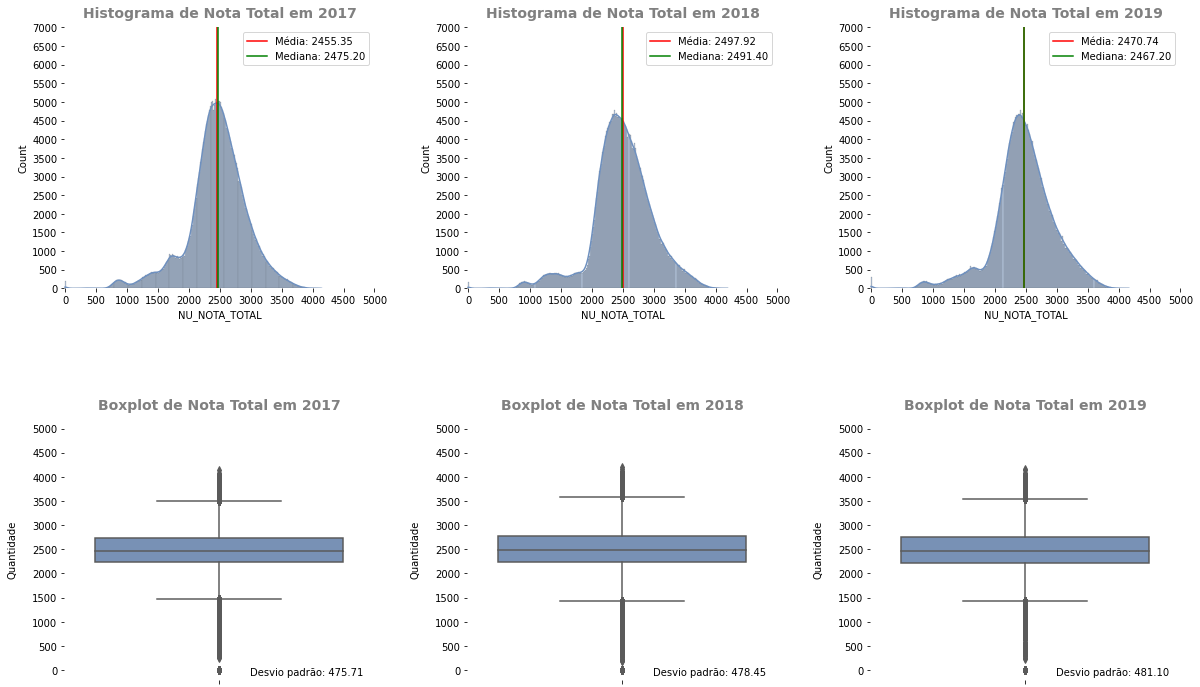

In [227]:
grid_nota('NU_NOTA_TOTAL')

Temos gráficos muito semelhantes, as médias e medianas da nota total sofreram poucas alterações durante os 3 anos, se observarmos o boxplot juntamente com o desvio padrão de cada ano, conclui-se que a distribuição também é muito semelhante.

### 6.1.2 Notas de Matemática

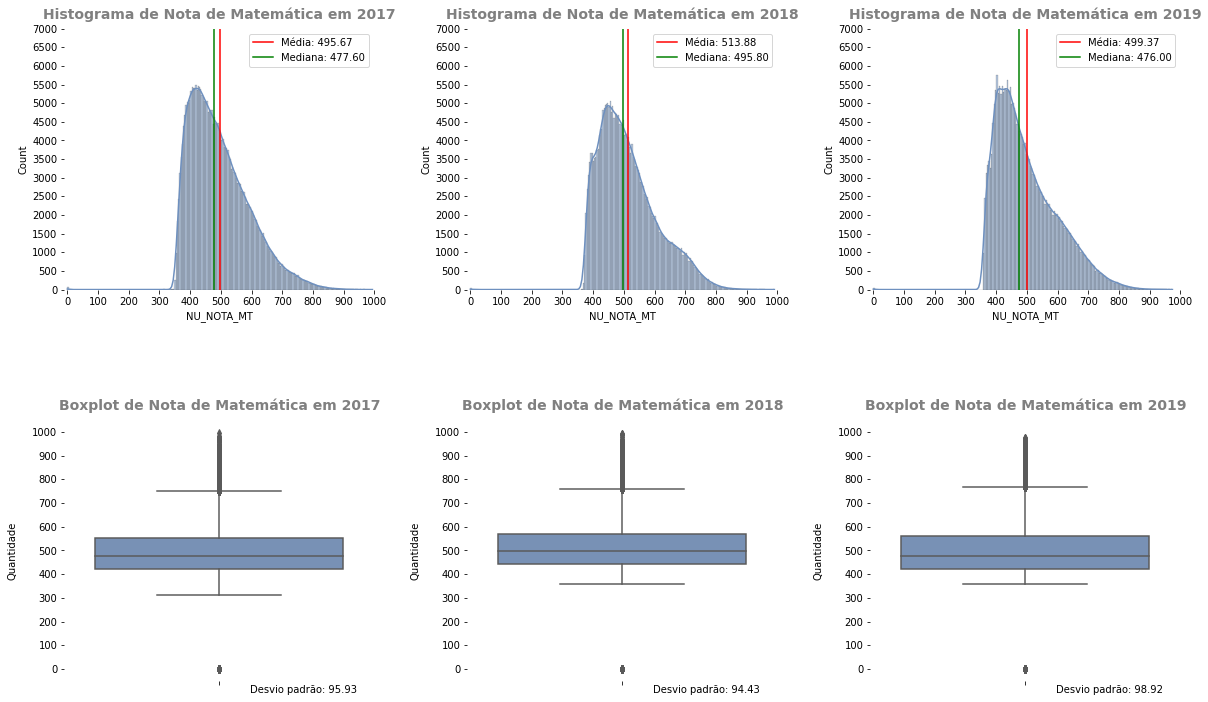

In [228]:
grid_nota('NU_NOTA_MT')

As notas de matemática também se distribuem de forma muito semelhante durante os 3 anos, mas olhando os histogramas podemos ver que há um aumento de quantidade de notas entre 600 e 750 no ano de 2018, o que implica nesse ano ter uma média e mediana maior que os outros.

### 6.1.3 Notas de Ciências da Natureza

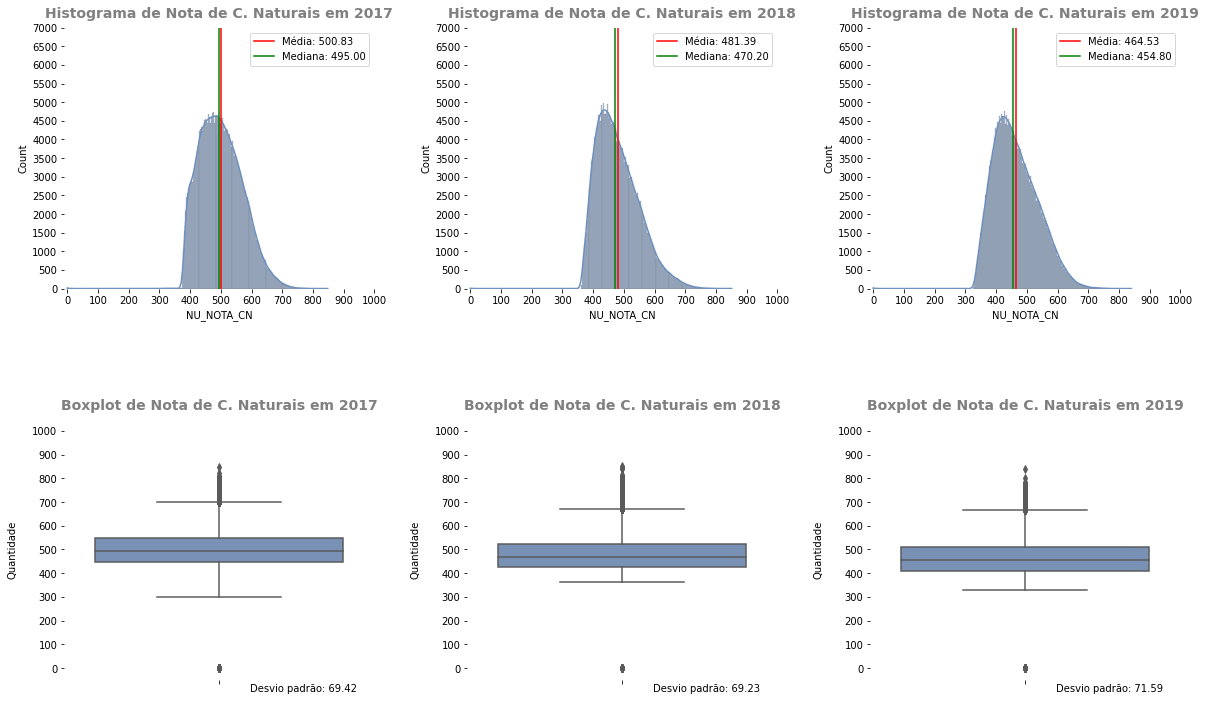

In [229]:
grid_nota('NU_NOTA_CN')

Em Ciências da Natureza, houve uma redução tanto na média quanto na mediana do ano 2017 para os dois seguintes, chegando a haver uma diferença de quase 40 em ambos de 2017 para 2019.

### 6.1.4 Notas de Ciências Humanas

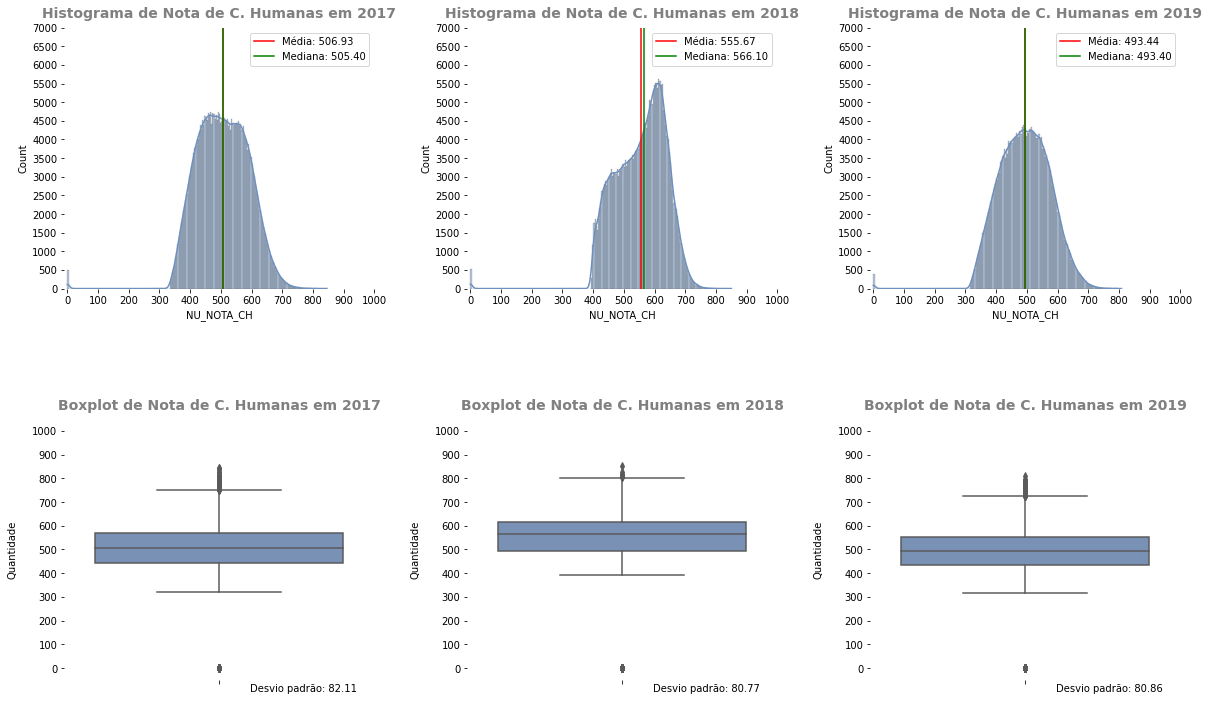

In [230]:
grid_nota('NU_NOTA_CH')

Em Ciências Humanas podemos perceber que em 2018 os dados estão concentrados nas notas maiores, de acordo com o boxplot aproximadamente 75% dos dados de 2018 sobre as notas de ciências humanas são maiores que aproximadamente 500 pontos e cerca de 50% dos dados estão acima de aproximadamente 570 pontos, enquanto que em 2017 e 2018 50% dos dados são inferiores a aproximadamente 520 pontos.

### 6.1.5 Notas de Linguagens e Códigos

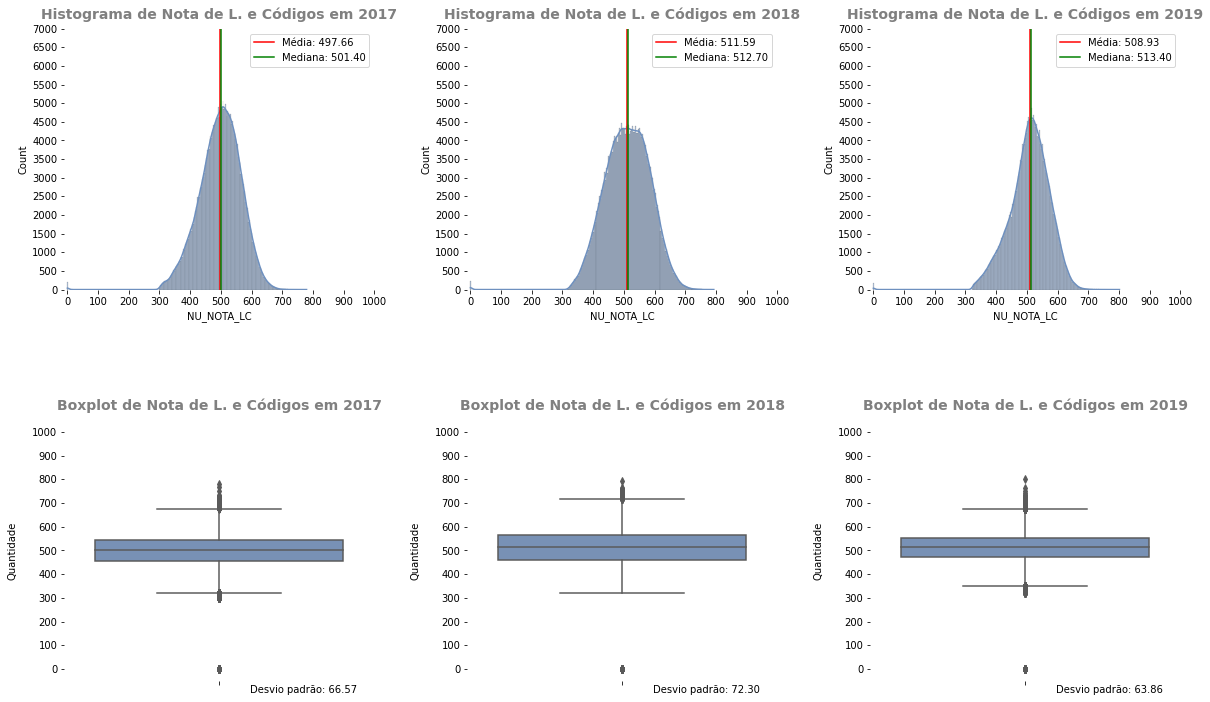

In [231]:
grid_nota('NU_NOTA_LC')

Em Linguagens e Códigos temos que em 2018 as notas foram distribuídas de forma mais espalhada, mas mesmo assim concentraram-se um pouco mais acima do que nos outros dois anos (os quais tiveram pouquíssimas diferenças).

### 6.1.6 Notas de Redação

Perceba que em redação as notas deixam de ser uma variável contínua e passa a ser uma variável discreta, composta por apenas 50 valores únicos.

In [232]:
enem_ba_2017['NU_NOTA_REDACAO'].nunique()

50

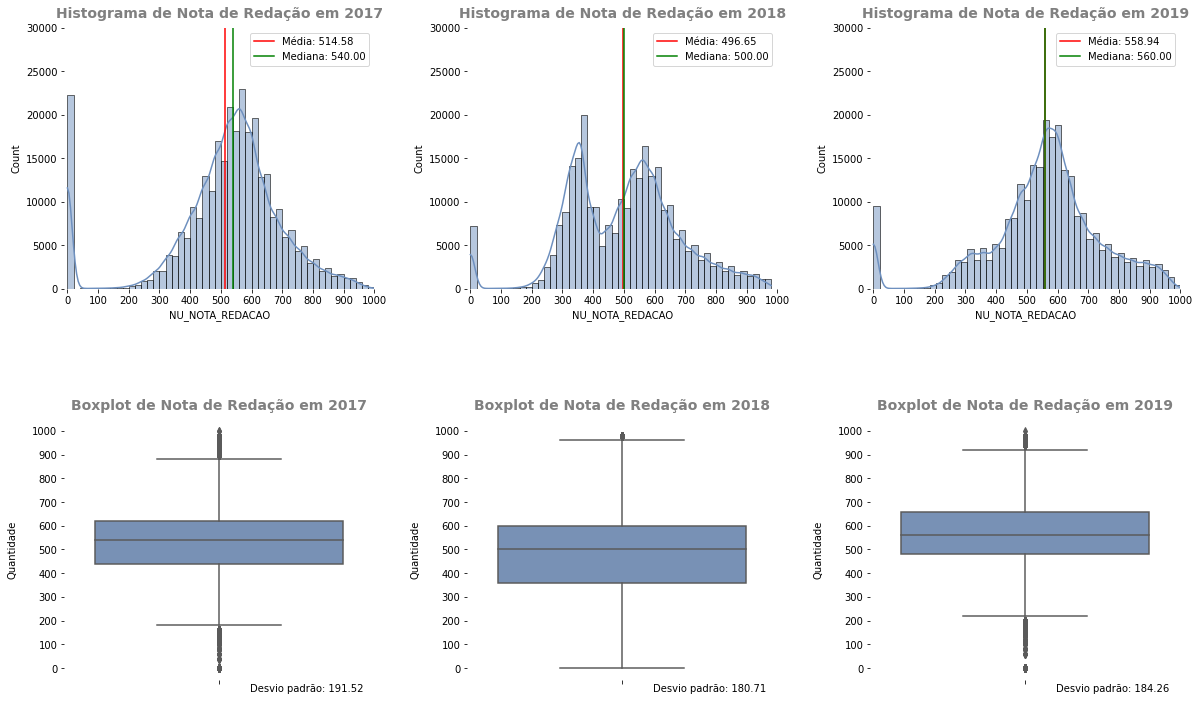

In [233]:
grid_nota('NU_NOTA_REDACAO')

É notável que em redação as notas distribuem-se mais (olhando o boxplot e o desvio padrão) e preenchem uma quantidade maior de notas do que as analisadas anteriormente.

O ano em que tivemos maiores notas de redação dentre os três foi em 2019 onde podemos observar que cerca de 75% das notas estão acima de 470 pontos e cerca de 50% das notas estão acima de 560 pontos.

### 6.1.7 Analisando a correlação entre as notas

In [234]:
def heat_corr(df):
  plt.subplots_adjust(wspace=0.4)
  sns.heatmap(data=df[notas].corr(), center=0, annot=True, cmap='vlag')
  plt.yticks(np.arange(6), ['C.Humanas', 'Matemática', 'C.Natureza', 'Linguagens', 'Redação', 'Total'])
  plt.xticks(np.arange(6), ['C.Humanas', 'Matemática', 'C.Natureza', 'Linguagens', 'Redação', 'Total'], rotation=30)
  plt.title('Correlações das notas em {}'.format(int(df['NU_ANO'].mode()[0])), fontsize=14, pad=10, color='grey', fontweight='heavy')


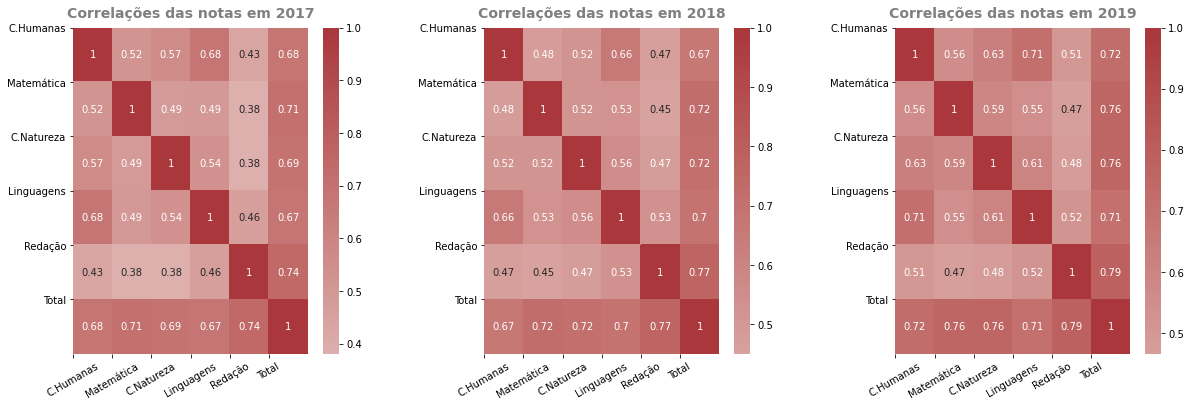

In [235]:
plt.figure(figsize=(20,6))
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  heat_corr(ano)
  i+=1

As notas que tiveram uma melhor correlação com a nota total em todos os anos foram as de Redação, observe que é uma correlação positiva, significa que quanto melhor uma pessoa se sair na prova de Redação, mais chances ela tem de ter um resultado melhor no final.

Já entre as próprias provas temos que a melhor correlação em todos os anos é entre as provas de Linguagens e Códigos e a de Ciências Humanas, uma possível explicação para isso é que desde 2017 elas são realizadas sempre no primeiro dia de Enem (um domingo), para confirmarmos essa HIPÓTESE precisaríamos analisar os dados dos anos anteriores a 2017, pois as ordens das provas eram diferentes e elas eram feitas durante o mesmo final de semana (daria uma boa análise).

# 7. Conclusões

Através de toda a análise realizada anteriormente, irei mapear as conclusões que pudemos ter acerca dos dados do Enem baiano nos anos de 2017, 2018 e 2019:<br><br>


1.	<b>Faltantes:</b>
    - 1.1	Nos três anos, mais do que 99% dos inscritos que faltam no 1º dia de prova deixam de ir no 2º também;
    - 1.2	Sejam as faltas apenas no 1º dia, apenas no 2º ou em ambos os dias, a maioria delas sempre ocorre com pessoas que não têm nem um carro e nem uma moto em suas casas.
    - 1.3.	Em todos os anos mais de 55% dos inscritos faltaram nos dois dias e também não possuíam veículos automotivos em casa.

2.	<b>Treineiros:</b>
    - 2.1.	Os treineiros são uma parcela muito pequena dos participantes do Enem, mas conseguiram, nos três anos estudados aqui, terem uma melhor distribuição de notas totais (notas mais altas).

3.	<b>Cor/Raça:</b>
    - 3.1.	Pardos ou pretos são aproximadamente 80% de todos os participantes do Enem na Bahia nos 3 anos.
    - 3.2.	Indígenas, negros e pardos são muito desfavorecidos no Enem, por questões históricas, pessoas pertencentes a esses grupos ainda têm dificuldade de inserirem-se na sociedade e na educação de forma igualitária.

4.	<b>Sexo:</b>
    - 4.1.	Em todos os anos a maior parte do público do Enem é feminino;
    - 4.2.	O sexo dos participantes rem pouca ou nenhuma relevância sobre as notas totais.

5.	<b>Renda:</b>
    - 5.1.	Em todos os anos, sem exceção, as notas infelizmente são muito impactadas tanto pela renda familiar quanto pela formação dos pais de cada participante da prova do Enem, isso deve-se a diversos fatores sociais presentes no nosso país e escancara ainda mais a distância entre ricos e pobres no Brasil. Quanto menor a renda familiar e quanto menor for a formação dos pais, menores tendem a serem as notas totais.

6.	<b>Tipos de escola:</b>
    - 6.1.	O ano de 2018 é o único no qual temos a média e a distribuição de notas totais do ensino público sendo superior à do ensino privado, mas em todos os anos aproximadamente 70% ou mais participantes não responderam sobre quais os seus tipos de ensino, dessa forma, isso reduz bastante o quanto podemos inferir sobre essa variável.

7.	<b>Acesso ao estudo de casa:</b>
    - 7.1.	Caso o participante não tenha acesso à internet ou não tenha acesso a algum meio de estudo digital (celular ou computador) em casa ele tende a ter uma nota total inferior, algo totalmente plausível, pois ele terá menos espaço de tempo no dia disponível para estudar.

8.	<b>Município:</b>
    - 8.1.	Salvador e Feira de Santana têm os dois maiores números de participantes no Enem na Bahia em todos os três anos, mas não estão entre as dez maiores medias de notas totais em nenhum dos três.

9.	<b>Notas:</b>
    - 9.1.	Dentre as notas a mudança mais significativa foi a de Ciências da Natureza, nela ouve uma redução constante de 2017 a 2019 de cerca de 40 pontos tanto de média quanto de mediana.
    - 9.2.	Em Ciências Humanas em 2018 as notas foram maiores do que nos outros dois anos.
    - 9.3.	Em 2019 tivemos as maiores notas de redação dentre os três anos, aproximadamente 50% das notas ficaram acima de 560 pontos nesse ano.
    - 9.4.	As notas que mais se correlacionam com a nota total são as de redação, talvez ela pese mais por ser única onde a nota máxima (1000) é alcançável.
    - 9.5.	Entre as próprias provas temos que a melhor correlação em todos os anos é entre as provas de Linguagens e Códigos e a de Ciências Humanas, uma possível explicação para isso é que de 2017 pra frente elas são realizadas sempre no primeiro dia de Enem (um domingo).






# 8. Fontes de dados

Dados do Enem: http://inep.gov.br/microdados

Dados do IBGE: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/15774-malhas.html?edicao=15874&t=downloads